
# Trabalho de Sistemas Inteligentes para a Bioinformática

Trabalho realizado no âmbito da unidade curricular de Sistemas Inteligentes para a Bioinformática.

Grupo constituído por:

    - Angelina Eiras PG42861
    - Carina Gonçalves PG45466
    - Rute Castro PG45475
    - Sónia Carvalho PG42882


Para a utilização deste notebook é necessário proceder às seguintes instalações:

In [1]:
# pip install git+https://github.com/jcapels/propythia.git@fix_dependencies
#ou download do ficheiro em formato zip
# pip install --upgrade pip
# pip install propythia-fix_dependencies.zip
# pip install -r requirements.txt

In [22]:
import pandas as pd
import scipy.cluster.hierarchy
import seaborn as sn
import numpy as np
from tensorflow import keras
from keras.optimizers.schedules import *
from propythia import *
from scipy import stats
from statsmodels.stats.weightstats import ztest as ztest
import statsmodels.api as statsmodels
import matplotlib.pyplot as plt
%matplotlib inline

import re
import random
import requests as r
from Bio import SeqIO
from io import StringIO
from collections import Counter
import seaborn as sns

from propythia.protein_descriptores import ProteinDescritors

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, f_classif, SelectPercentile, r_regression
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, matthews_corrcoef, f1_score, roc_auc_score, log_loss, hinge_loss, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, LeaveOneOut
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.stats import uniform, shapiro, levene, mannwhitneyu, ttest_ind
from scipy.cluster.hierarchy import dendrogram, linkage 

from sklearn.datasets import load_iris

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt

AttributeError: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)

------------------------------------------------------------------------------------------------------------------------------------------------------

#  Fase 1 

## Exploração inicial

Nesta secção será feita a exploração inicial dos dados, incluindo os dataset provenientes do desafio Kaggle (https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction).
O objetivo do trabalho é prever a termoestabilidade de variantes enzimáticas. As enzimas são proteínas que actuam como catalisadores nas reações químicas dos organismos vivos. Compreender e prever com precisão a sua estabilidade é um problema fundamental na biotecnologia, uma vez que melhorias na estabilidade da enzima podem reduzir os custos e aumentar a velocidade com que os cientistas descobrem novos conceitos.
Os dados de termoestabilidade (temperatura de fusão) foram medidos experimentalmente e incluem sequências naturais, bem como sequências modificadas com mutações únicas ou múltiplas nas sequências naturais.



## Pré-processamento

O primeiro passo será juntar os dois datasets provenientes do desafio - `train` (dataset original) e `train_update` (dataset com atualizações), e juntá-los num único DataFrame.
De seguida, vamos extender os dados existentes com descritores físico-químicos obtidos através da plataforma Propythia, desenvolvida na Universidade do Minho. Estes descritores serão utilizados ao longo do trabalho.

In [11]:
# Ler os datasets provenientes do desafio
#train = pd.read_csv('datasets/train_nanFREE.csv', delimiter = ',')
train = pd.read_csv("C:/Users/sonia/Desktop/SIB_v1/kag/train.csv", delimiter = ',')
#updates = pd.read_csv('datasets/train_updates_20220929.csv', delimiter = ',')
updates = pd.read_csv('C:/Users/sonia/Desktop/SIB_v1/kag/train_updates_20220929.csv', delimiter = ',')

#Verificar tamanho e primeiras linhas/colunas
print(train.shape)
train.head()


(31390, 5)


,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [12]:
#Verificar tamanho e primeiras linhas/colunas
print(updates.shape)
updates.head()

(2434, 5)


,seq_id,protein_sequence,pH,data_source,tm
0,69,NaN,NaN,NaN,NaN
1,70,NaN,NaN,NaN,NaN
2,71,NaN,NaN,NaN,NaN
3,72,NaN,NaN,NaN,NaN
4,73,NaN,NaN,NaN,NaN


In [13]:
# Colunas para atualizar no dataset de treino
col_to_update = ['protein_sequence', 'pH', 'tm']

# Atualizar o seq_id
to_update_id = list(updates[~updates.protein_sequence.isna()].seq_id)

# Fazer o update só nas linhas que são necessárias
updates = updates[updates.seq_id.isin(to_update_id)].set_index('seq_id')

# Atualizar os valores no dataset de treino
train.loc[to_update_id, col_to_update] = updates[col_to_update].values

# Verificar se está com os updates
pd.concat([train[train.seq_id.isin(to_update_id)].set_index('seq_id'), updates], axis = 1)

#Nao precisamos dos links - drop do data_source
#train.drop(['data_source'], axis=1, inplace=True)

# Retirar os pHs maiores que 14 (pois não tem significado biológico)
train = train[train["pH"]<=14] 

#Verificar tamanho e primeiras linhas/colunas
print(train.shape)
train.head()

(31100, 5)


,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


### Gerar descritores

Dos métodos disponíveis na classe `ProteinDescriptors`, faz sentido utilizar cinco destes pelos seguintes motivos:
- `get_all_aac()`: descritores relacionados com a composição dos aminoácidos;
- `get_all_physicochemical()`: tem 16 features disponíveis relativas às propriedades fisico-químicas, incluindo include length, charge,charge density, formula (number of C,H,N,O and S in the sequence), number of 4 types of molecular bonds (total, single,double and hydrogen bonds), the molecular weight, GRAVY, aromacity, isoelectric point, instability index, values for secondary structures (a-helix, turns and b-sheets), molar extinction coefficient, flexibility, aliphatic index, boman index and hydrophobic ratio;
- `get_all_base_class()`: descritores relativos à classe base dos peptidos, permitindo calcular the sequence moment, the global averaging descriptor, hydrophocity moments, arcs, autocorrelation and cross correlation of amino acid values for a given descriptor value;
- `get_all_sequenceorder()`: descritores da ordem da sequência, permitindo calcular sequence order coupling numbers e quasi
sequence order values;
- `get_all_correlation()`: descritores de correlação, incluindo Normalized Moreau-Broto autocorrelation, Moran Autocorrelation e Geary autocorrelation.

Foi também testada a possibilidade de utilizar o `get_all()`, que também englobaria estes, mas o peso computacional deste método era demasiado grande.
Por questões de "performance" - e por forma a salvaguardar o progresso do nosso trabalho, cada um dos métodos mencionados foi calculado individualmente e guardado em ficheiros dedicados, procedendo-se à sua agregação num momento posterior.

In [32]:
# Calcular toda a informação extra
print("running get_all_aac")
result_all_aac : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_aac(n_jobs=96)
result_all_aac.to_csv('datasets/get_all_aac.csv')

print("running get_all_physicochemical")
result_all_physicochemical : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_physicochemical(n_jobs=96)
result_all_physicochemical.to_csv('datasets/get_all_physicochemical.csv')

print("running get_all_base_class")
result_all_base_class : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_base_class(window=5, n_jobs=96)
result_all_base_class.to_csv('datasets/get_all_base_class.csv')

print("running get_all_sequenceorder")
result_all_sequenceorder : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_sequenceorder(maxlag_socn=5,maxlag_qso=5, n_jobs=96) # Falhou
result_all_sequenceorder.to_csv('datasets/get_all_sequenceorder.csv')

print("running get_all_correlation")
result_all_correlation : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_correlation(n_jobs=96)
result_all_correlation.to_csv('datasets/get_all_correlation.csv')

running get_all_aac
running get_all_physicochemical
running get_all_base_class
running get_all_sequenceorder
running get_all_correlation
merging
dumping


In [25]:
# Junção dos resultados obtidos num único dataset - all_descriptors.csv
datasets = [
   'datasets/get_all_physicochemical.csv',
   'datasets/get_all_sequenceorder.csv',
   'datasets/get_all_correlation.csv',
   'datasets/get_all_base_class.csv',
   'datasets/get_all_aac.csv'
   ]

dataset = pd.DataFrame()
for dataset in datasets:
   dataset = pd.read_csv(dataset, delimiter = ',')
   dataset = dataset if dataset.empty else dataset.merge(dataset, how='inner', on = "protein_sequence", validate="one_to_one")
# dataset = dataset.loc[:,~dataset.columns.duplicated()] # remove duplicates não funciona porque o join() mete sufixos quando os nomes são iguais

print("dumping")
dataset.to_csv('datasets/all_descriptors.csv') 

#Visualizar tamanho e primeiras linhas/colunas
print(dataset.shape)
dataset.head()

C:\Users\SOA5BRG\AppData\Local\Temp\ipykernel_17520\2114072168.py:13: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0.1_x', 'tm_x', 'Unnamed: 0_x', 'pH_x', 'seq_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  descriptors_df = dataframe if descriptors_df.empty else descriptors_df.merge(dataframe, how='inner', on = "protein_sequence", validate="one_to_one")


dumping
(28701, 9270)


,Unnamed: 0.1_x,Unnamed: 0_x,seq_id_x,protein_sequence,pH_x,tm_x,length,charge,chargedensity,formulaC,...,VVL,VVK,VVM,VVF,VVP,VVS,VVT,VVW,VVY,VVV
0,0,0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341.0,-1.732,-0.000048,1622,...,0,1,0,0,0,0,1,0,0,0
1,1,1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286.0,-12.537,-0.000382,1385,...,1,0,0,0,0,0,0,0,0,0
2,2,2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497.0,11.513,0.000215,2290,...,0,0,0,0,0,0,0,0,0,0
3,3,3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265.0,-20.606,-0.000699,1293,...,0,0,0,0,0,0,0,0,0,0
4,4,4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451.0,-21.900,-0.000138,6948,...,0,0,0,0,1,3,0,0,0,2


### Pré-processamento de dados
Com a junção dos resultados obtidos a partir do ProteinDescriptors, foram introduzidos alguns artefactos no dataset, nomeadamente colunas duplicadas, marcadas com `_x`, `_y`, entre outros.
Torna-se assim necessário efetuar pré-processamento antes de proceder à análise dos dados propriamente dita.

In [14]:
# Carregar o dataset que inclui todos os descritores
#dataset = pd.read_csv('datasets/all_descriptors.csv', delimiter = ',')
dataset = pd.read_csv('C:/Users/sonia/Desktop/SIB_v1/kag/all_descriptors.csv', delimiter = ',')

#Visualizar tamanho e tipo de dados
print(dataset.shape, dataset.dtypes)
#Sumário de medidas estatísticas gerais
dataset.describe()

# As variáveis têm valores em gamas muito diferentes, pelo que será necessário proceder a um método de estandardização dos dados
# Há também colunas duplicadas  resultantes do processo de merge(), que ficaram com sufixos _x e _y, outras que são Unnamed
# A coluna seq_id tem mais valores que o indicado pela shape

(28701, 8426) Unnamed: 0.1          int64
Unnamed: 0            int64
seq_id                int64
protein_sequence     object
pH                  float64
                     ...   
VVS                   int64
VVT                   int64
VVW                   int64
VVY                   int64
VVV                   int64
Length: 8426, dtype: object


,Unnamed: 0.1,Unnamed: 0,seq_id,pH,tm,A,R,N,D,C,...,VVL,VVK,VVM,VVF,VVP,VVS,VVT,VVW,VVY,VVV
count,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,...,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000
mean,14350.000000,15551.295878,15551.295878,6.939714,49.366046,7.808642,5.389442,4.183468,5.523544,1.437282,...,0.170865,0.128393,0.041741,0.075990,0.109717,0.173374,0.128114,0.020975,0.055294,0.160587
std,8285.409374,9222.759275,9222.759275,0.618851,13.722043,2.779774,2.229637,1.834959,1.771067,1.292683,...,0.457690,0.470298,0.219756,0.293677,0.463418,0.516936,0.491245,0.231144,0.244326,0.444982
min,0.000000,0.000000,0.000000,1.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7175.000000,7450.000000,7450.000000,7.000000,42.300000,5.863000,3.969000,2.991000,4.380000,0.625000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14350.000000,15190.000000,15190.000000,7.000000,48.000000,7.517000,5.162000,4.035000,5.446000,1.217000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21525.000000,23711.000000,23711.000000,7.000000,53.500000,9.362000,6.513000,5.161000,6.518000,1.935000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,28700.000000,31389.000000,31389.000000,11.000000,130.000000,29.866000,24.540000,31.990000,20.530000,16.071000,...,7.000000,19.000000,5.000000,5.000000,20.000000,13.000000,20.000000,12.000000,3.000000,11.000000


In [15]:
# Remove colunas que contém o nome "Unnamed" no início, chamam-se '_', ou têm sufixo indicativo de duplicado
dataset = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')]
dataset = dataset.loc[:, ~dataset.columns.str.fullmatch('_')]
# encontrar nomes de colunas duplicadas e removê-las
# seq_id_x.1  tm_x.1  seq_id_y.1  tm_y.1
for col in filter(lambda x:x.endswith('_y'), dataset.columns):
    dataset = dataset.drop(col, axis=1)
for col in filter(lambda x:x.endswith('_x'), dataset.columns):
    dataset = dataset.rename(columns={col:col[-2]})
for col in filter(lambda x:'0'<=x[-1]<='9' and x[-2]=='.', dataset.columns):
    dataset = dataset.drop(col, axis=1)


In [9]:
#colunas que contém o nome "Unnamed" no início, chamam-se '_', ou têm sufixo indicativo de duplicado
for col in dataset.columns:
    if col.startswith("Unnamed") or col.startswith("_") or col.endswith("_x") or col.endswith("_y") or "0"<=col[0]<"9":
        print(col)


In [16]:
# Confirmar que não há dados omissos
set(dataset.isnull().sum())
# Só há valores 0, o que indica que todas as colunas tem 0 valores omissos

{0}

In [17]:
# Eliminar linhas duplicadas, e as duas colunas identificadoras das sequências ("seq_id", "protein_sequence") para ser possível fazer a análise dos dados
# Podemos eliminar a coluna com a sequência propriamente dita, uma vez que já extraímos as features relevantes a partir dela (features vindas do ProteinDescriptors)
dataset_dropped = dataset.drop_duplicates(subset = "seq_id")
dataset_dropped = dataset_dropped.drop(columns=['seq_id', 'protein_sequence'], axis=1)
dataset_dropped.shape

(28701, 8422)

### Análise exploratória inicial
Na análise exploratória inicial, tentámos resumir e visualizar as características principais das "features", com recurso a alguns métodos estatísticos.

In [20]:
#Resumo das principais métricas estatísticas
dataset_dropped.describe()

,pH,tm,A,R,N,D,C,E,Q,G,...,VVL,VVK,VVM,VVF,VVP,VVS,VVT,VVW,VVY,VVV
count,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,...,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000
mean,6.939714,49.366046,7.808642,5.389442,4.183468,5.523544,1.437282,7.148703,4.101255,6.912200,...,0.170865,0.128393,0.041741,0.075990,0.109717,0.173374,0.128114,0.020975,0.055294,0.160587
std,0.618851,13.722043,2.779774,2.229637,1.834959,1.771067,1.292683,2.504653,1.909087,2.550587,...,0.457690,0.470298,0.219756,0.293677,0.463418,0.516936,0.491245,0.231144,0.244326,0.444982
min,1.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,42.300000,5.863000,3.969000,2.991000,4.380000,0.625000,5.613000,2.917000,5.263000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,48.000000,7.517000,5.162000,4.035000,5.446000,1.217000,6.977000,3.876000,6.667000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,53.500000,9.362000,6.513000,5.161000,6.518000,1.935000,8.482000,5.046000,8.260000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11.000000,130.000000,29.866000,24.540000,31.990000,20.530000,16.071000,24.658000,24.346000,60.920000,...,7.000000,19.000000,5.000000,5.000000,20.000000,13.000000,20.000000,12.000000,3.000000,11.000000


Verificámos ter um número de features superior a 8,000. Algumas features têm um intervalo entre quartis igual a zero, o que tendencialmente não trará informação adicional ao nosso modelo, e poderá aumentar a sua complexidade. Assim, decidimos reduzir a dimensão do dataset através da eliminação de features com variância inferior a um certo threshold (que consideramos 0.5).


In [23]:
#Aplicar um threshold para seleccionar variáveis
vt = VarianceThreshold(threshold=0.5)
mask = vt.fit(dataset_dropped).get_support(indices=False)
dataset = dataset_dropped.loc[:, mask]

#Verificar se há colunas que possam ser interpretadas como binárias (apenas dois valores admissíveis)
binary_cols= [col for col in dataset.columns if len(dataset[col].unique())==2]
print("Binary columns:", binary_cols)

#Sumário das medidas estatísticas depois de eliminar features com variância inferior a 0.5
dataset.describe()

Binary columns: []


,tm,A,R,N,D,C,E,Q,G,H,...,TGL,TTT,TVT,VEK,VLD,VLE,VKE,VPE,VSA,VTG
count,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,...,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000
mean,49.366046,7.808642,5.389442,4.183468,5.523544,1.437282,7.148703,4.101255,6.912200,2.207858,...,0.159263,0.116128,0.128950,0.195150,0.181178,0.219609,0.168879,0.138114,0.175987,0.149995
std,13.722043,2.779774,2.229637,1.834959,1.771067,1.292683,2.504653,1.909087,2.550587,1.138940,...,0.770063,0.714995,0.917878,0.851397,0.746790,0.718904,0.736610,1.331978,0.737452,0.907485
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.300000,5.863000,3.969000,2.991000,4.380000,0.625000,5.613000,2.917000,5.263000,1.468000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,7.517000,5.162000,4.035000,5.446000,1.217000,6.977000,3.876000,6.667000,2.134000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,53.500000,9.362000,6.513000,5.161000,6.518000,1.935000,8.482000,5.046000,8.260000,2.841000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,130.000000,29.866000,24.540000,31.990000,20.530000,16.071000,24.658000,24.346000,60.920000,14.634000,...,39.000000,82.000000,51.000000,46.000000,38.000000,32.000000,38.000000,82.000000,37.000000,51.000000


Ao selecionar as features com uma variância superior a 0.5, foi possível reduzir a dimensão do dataset (para um número de features igual a 97).
Constatámos que não existem colunas que possam ser interpretadas com binárias.

Procedeu-se então à análise de distribuição de cada feature.

array([[<AxesSubplot: title={'center': 'length'}>,
        <AxesSubplot: title={'center': 'charge'}>,
        <AxesSubplot: title={'center': 'formulaC'}>,
        <AxesSubplot: title={'center': 'formulaH'}>,
        <AxesSubplot: title={'center': 'formulaN'}>,
        <AxesSubplot: title={'center': 'formulaO'}>,
        <AxesSubplot: title={'center': 'formulaS'}>,
        <AxesSubplot: title={'center': 'MW_modlamp'}>,
        <AxesSubplot: title={'center': 'IsoelectricPoint'}>,
        <AxesSubplot: title={'center': 'Instability_index'}>,
        <AxesSubplot: title={'center': 'Molar_extinction_coefficient_reduced'}>],
       [<AxesSubplot: title={'center': 'Molar_extinction_coefficient_oxidized'}>,
        <AxesSubplot: title={'center': 'aliphatic_index'}>,
        <AxesSubplot: title={'center': 'tausw1'}>,
        <AxesSubplot: title={'center': 'tausw2'}>,
        <AxesSubplot: title={'center': 'tausw3'}>,
        <AxesSubplot: title={'center': 'tausw4'}>,
        <AxesSubplot: title

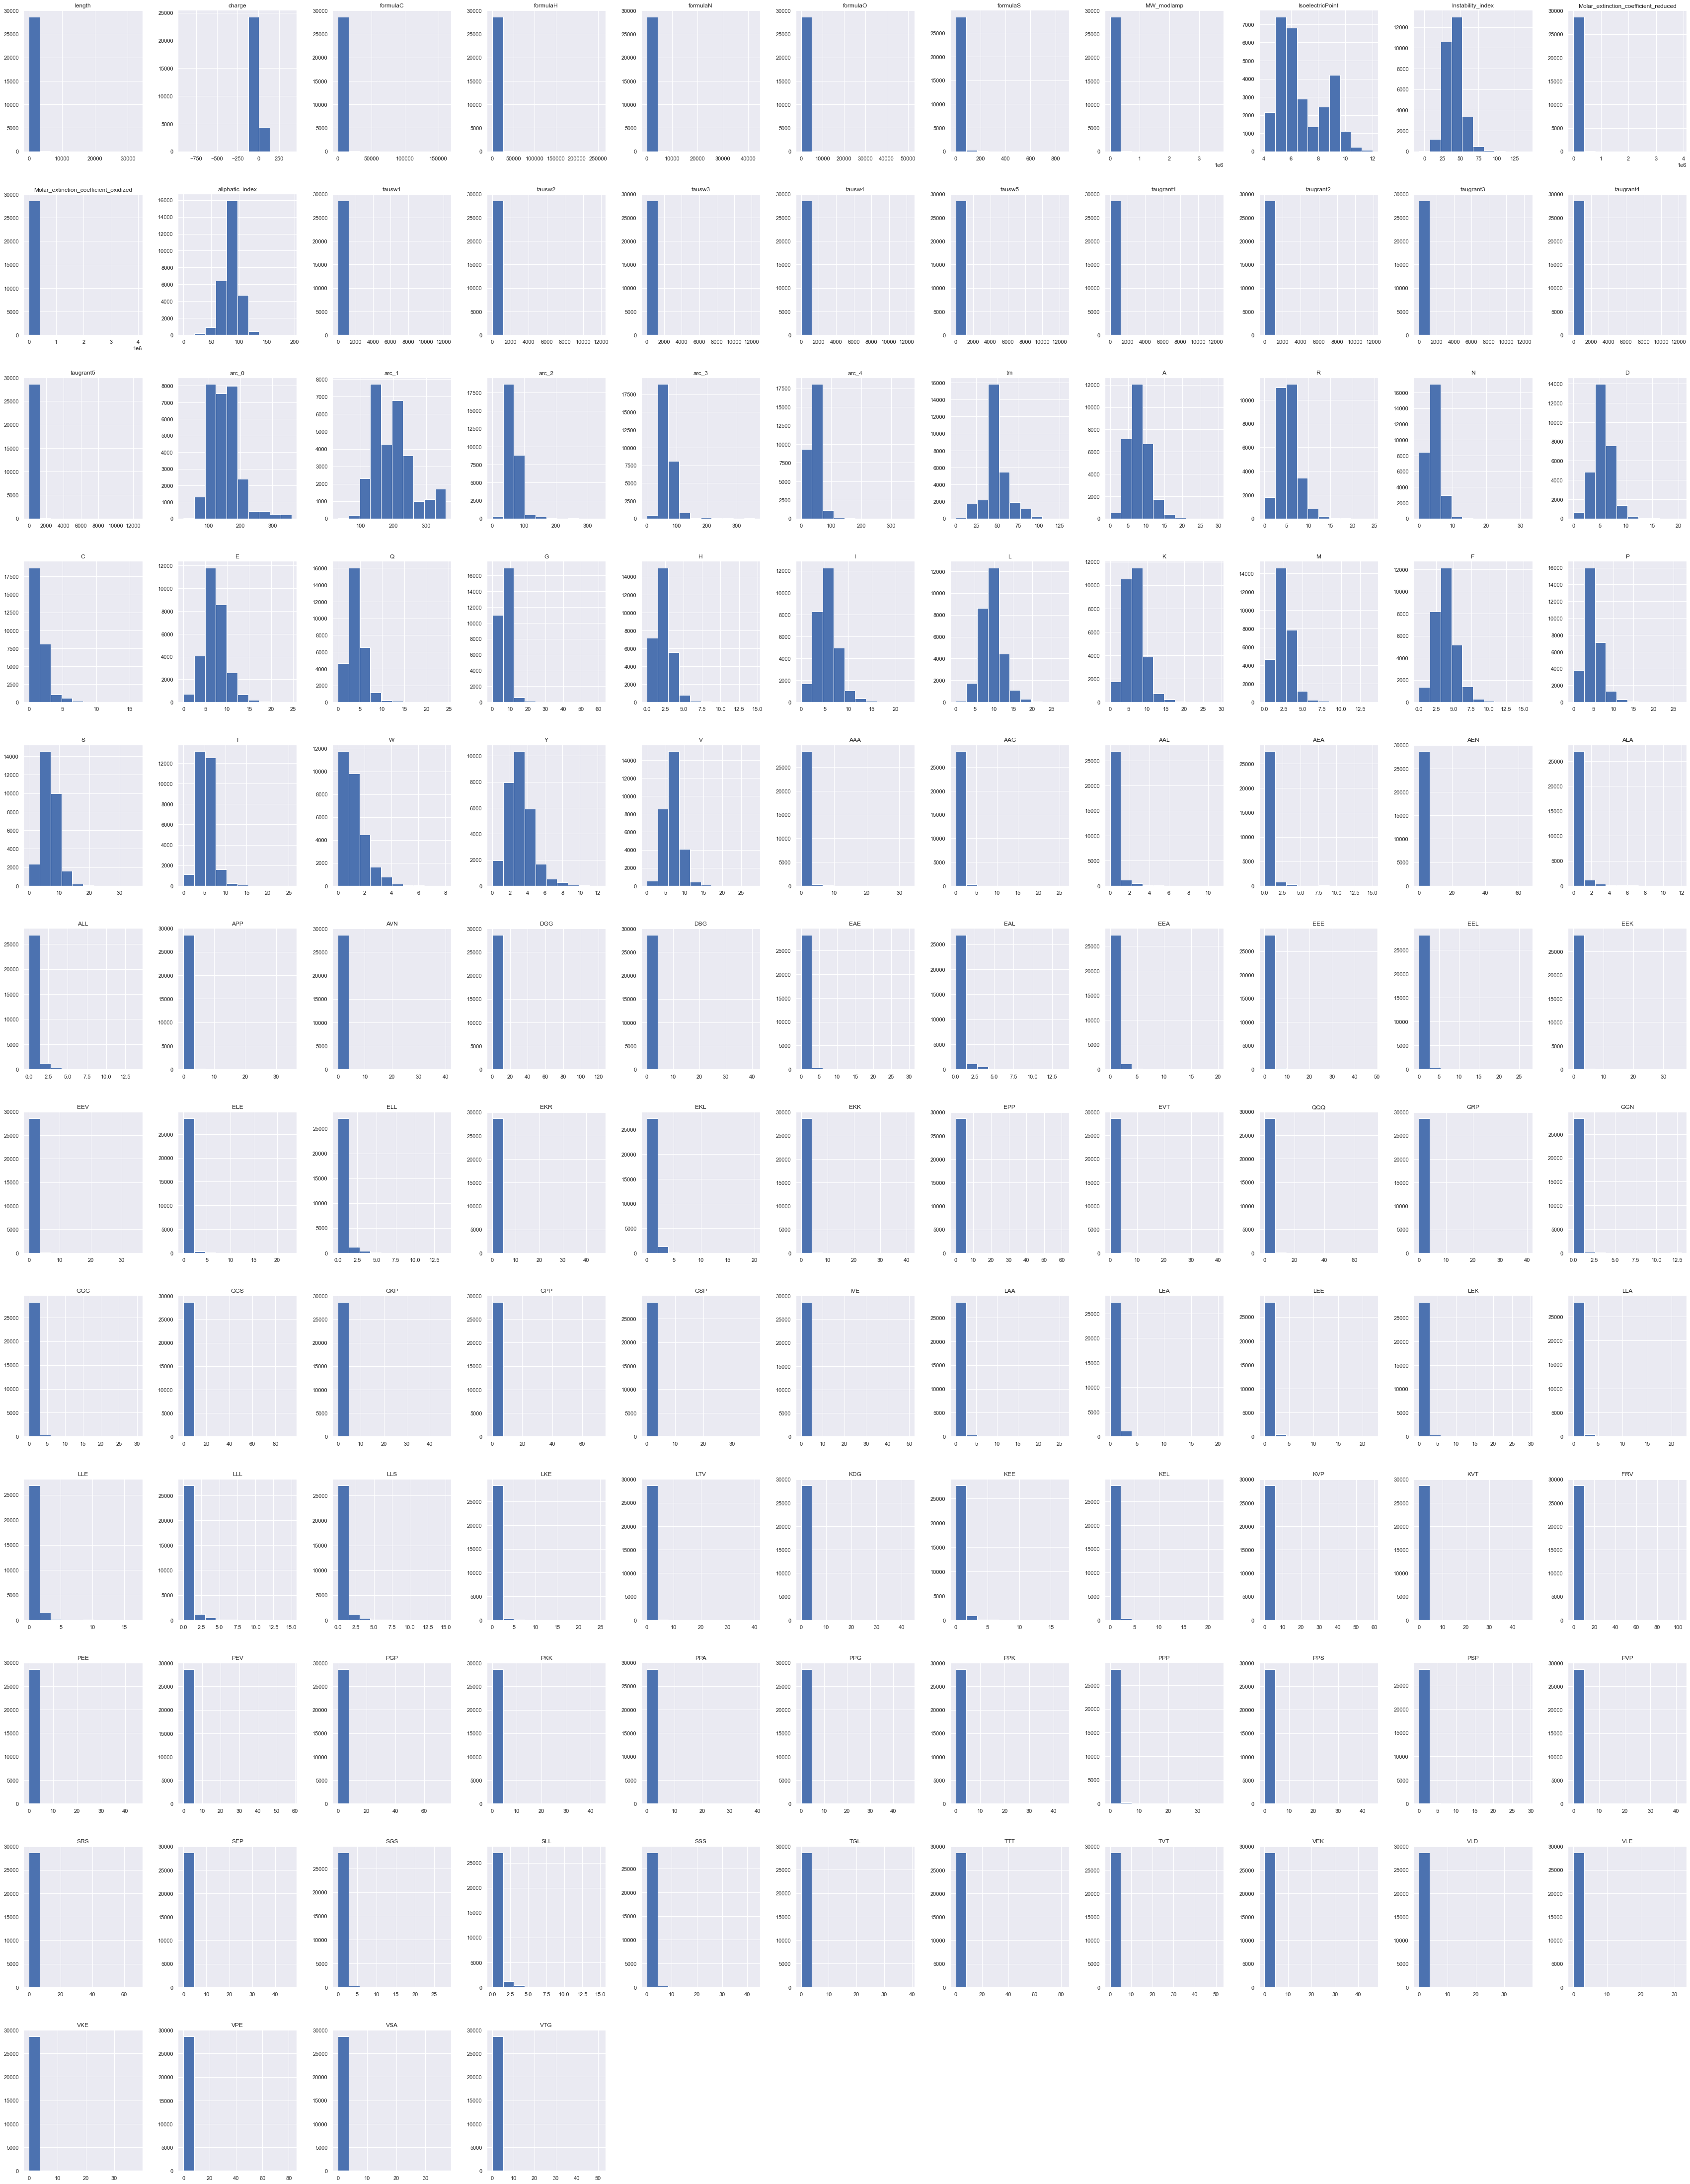

In [16]:
#Desenho de histogramas para visualização da distribuição das features
dataset.hist(figsize=(60,80))

Através da análise dos histogramas, visualizamos heterogeneidade nas distribuições das features. Algumas têm distribuições marcadamente assimétricas. Uma vez que pode haver "outliers" a extremar as gamas de valores, efetuámos normalização dos valores para uma escala comum, através de `StandardScaler`.

Antes: (28701, 96) (28701, 1)
Depois: (28344, 96) (28344, 1)


array([[<AxesSubplot: title={'center': 'A'}>,
        <AxesSubplot: title={'center': 'R'}>,
        <AxesSubplot: title={'center': 'N'}>,
        <AxesSubplot: title={'center': 'D'}>,
        <AxesSubplot: title={'center': 'C'}>,
        <AxesSubplot: title={'center': 'E'}>,
        <AxesSubplot: title={'center': 'Q'}>,
        <AxesSubplot: title={'center': 'G'}>,
        <AxesSubplot: title={'center': 'H'}>,
        <AxesSubplot: title={'center': 'I'}>],
       [<AxesSubplot: title={'center': 'L'}>,
        <AxesSubplot: title={'center': 'K'}>,
        <AxesSubplot: title={'center': 'M'}>,
        <AxesSubplot: title={'center': 'F'}>,
        <AxesSubplot: title={'center': 'P'}>,
        <AxesSubplot: title={'center': 'S'}>,
        <AxesSubplot: title={'center': 'T'}>,
        <AxesSubplot: title={'center': 'W'}>,
        <AxesSubplot: title={'center': 'Y'}>,
        <AxesSubplot: title={'center': 'V'}>],
       [<AxesSubplot: title={'center': 'AAA'}>,
        <AxesSubplot: title={'

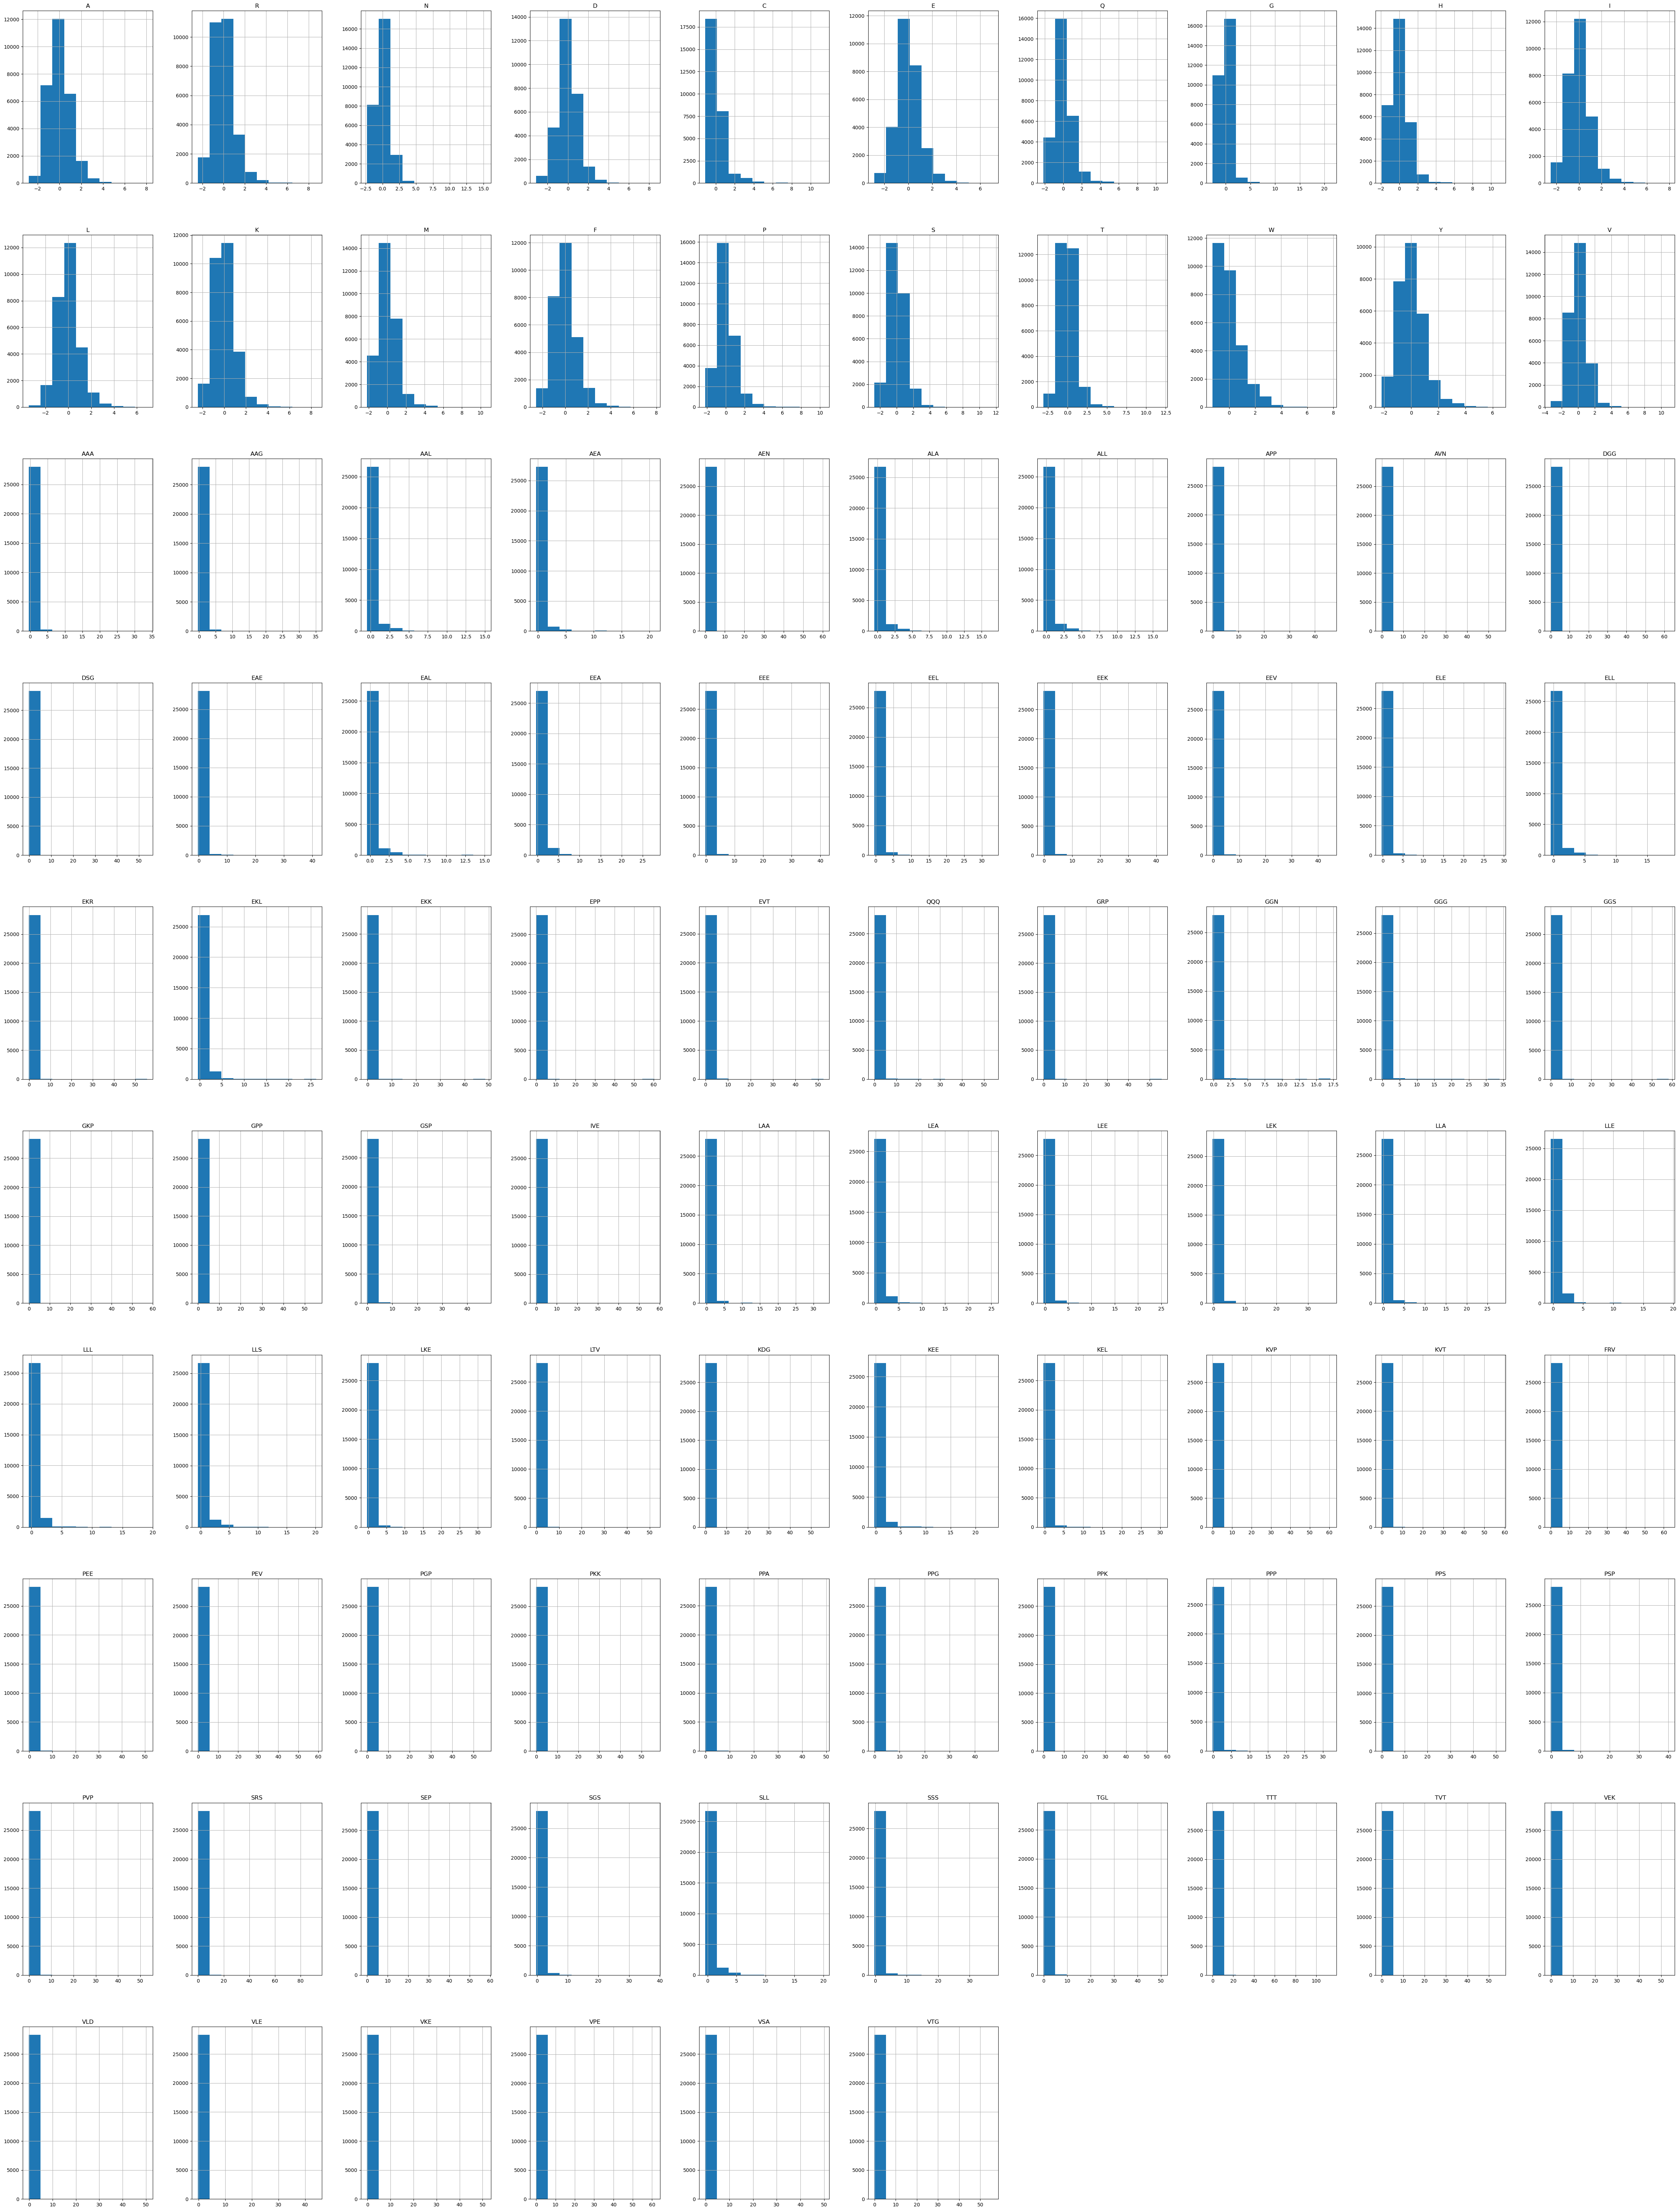

In [26]:
# Separar dados em X e Y para aplicar o scaler apenas às features (X)
Y_dataset = dataset["tm"].to_frame(name = "tm")
X_dataset = dataset.drop("tm", axis=1)
#Verificar tamanho de X e Y
print("Antes:", X_dataset.shape, Y_dataset.shape)

# Remoção de outliers
X_dataset = X_dataset[(np.abs(stats.zscore(dataset["tm"])) < 3)]
Y_dataset = Y_dataset[(np.abs(stats.zscore(dataset["tm"])) < 3)]
#Verificar tamanho de X e Y depois de remoção de outliers
print("Depois:", X_dataset.shape, Y_dataset.shape)

# Fazer normalização dos dados de X
data = StandardScaler().fit(X_dataset)
data_st = data.transform(X_dataset)

# Sumariar os dados transformados (resultado é array numpy e não panda dataframe)
np.set_printoptions(precision=3)

# Converter de novo a pandas dataframe 
data_scale = pd.DataFrame(data_st, index=X_dataset.index, columns=X_dataset.columns)

# Visualização de features depois de estandardização
data_scale.hist(figsize=(60,80))
#Resumo de medidas estatísticas depois de estandardização
data_scale.describe()


Confirmamos que as features já têm os valores num epectro mais semelhante, na gama das unidades e centrada em zero.

Avaliámos de seguida as correlações entre as diferentes features do dataset.


,A,R,N,D,C,E,Q,G,H,I,...,TGL,TTT,TVT,VEK,VLD,VLE,VKE,VPE,VSA,VTG
A,1.000000,0.038367,-0.283563,-0.228324,-0.135407,-0.066577,-0.044443,0.167569,-0.121499,-0.197928,...,-0.014690,-0.007948,-0.018365,-0.027860,-0.022357,-0.007451,-0.030863,-0.014520,0.038098,-0.005765
R,0.038367,1.000000,-0.235514,-0.098649,-0.017936,0.135225,-0.041070,-0.029746,-0.012815,-0.210232,...,-0.013988,-0.039266,-0.025157,-0.031390,0.015561,0.040887,-0.027082,0.002222,-0.027343,-0.018694
N,-0.283563,-0.235514,1.000000,0.150205,0.093038,-0.209825,-0.020682,-0.147527,-0.133207,0.233727,...,-0.025651,0.017912,-0.009556,-0.010218,-0.022345,-0.066709,-0.012643,-0.023629,-0.027075,-0.016277
D,-0.228324,-0.098649,0.150205,1.000000,-0.025737,0.099353,-0.112927,-0.204589,-0.024403,0.158104,...,-0.030657,-0.007951,-0.006431,-0.004878,0.031900,-0.020934,0.013865,-0.004717,-0.016002,-0.010118
C,-0.135407,-0.017936,0.093038,-0.025737,1.000000,-0.212421,0.033148,-0.017054,0.091560,-0.157461,...,0.020386,-0.003823,0.011077,-0.021936,-0.011986,-0.015678,-0.008004,-0.000894,-0.004112,0.006114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VLE,-0.007451,0.040887,-0.066709,-0.020934,-0.015678,0.105315,0.024521,-0.051848,0.013585,-0.055742,...,0.581246,0.221388,0.642779,0.638333,0.630014,1.000000,0.615376,0.696231,0.594598,0.636889
VKE,-0.030863,-0.027082,-0.012643,0.013865,-0.008004,0.087040,0.023913,-0.033625,-0.014189,-0.017633,...,0.679716,0.227685,0.737030,0.714657,0.676223,0.615376,1.000000,0.785157,0.684328,0.724849
VPE,-0.014520,0.002222,-0.023629,-0.004717,-0.000894,0.032968,-0.010884,-0.015214,-0.005167,-0.009294,...,0.772171,0.259335,0.852945,0.822335,0.779763,0.696231,0.785157,1.000000,0.769137,0.851268
VSA,0.038098,-0.027343,-0.027075,-0.016002,-0.004112,-0.011872,0.005978,-0.011569,-0.007768,-0.020278,...,0.686408,0.252233,0.729541,0.678896,0.656717,0.594598,0.684328,0.769137,1.000000,0.728771


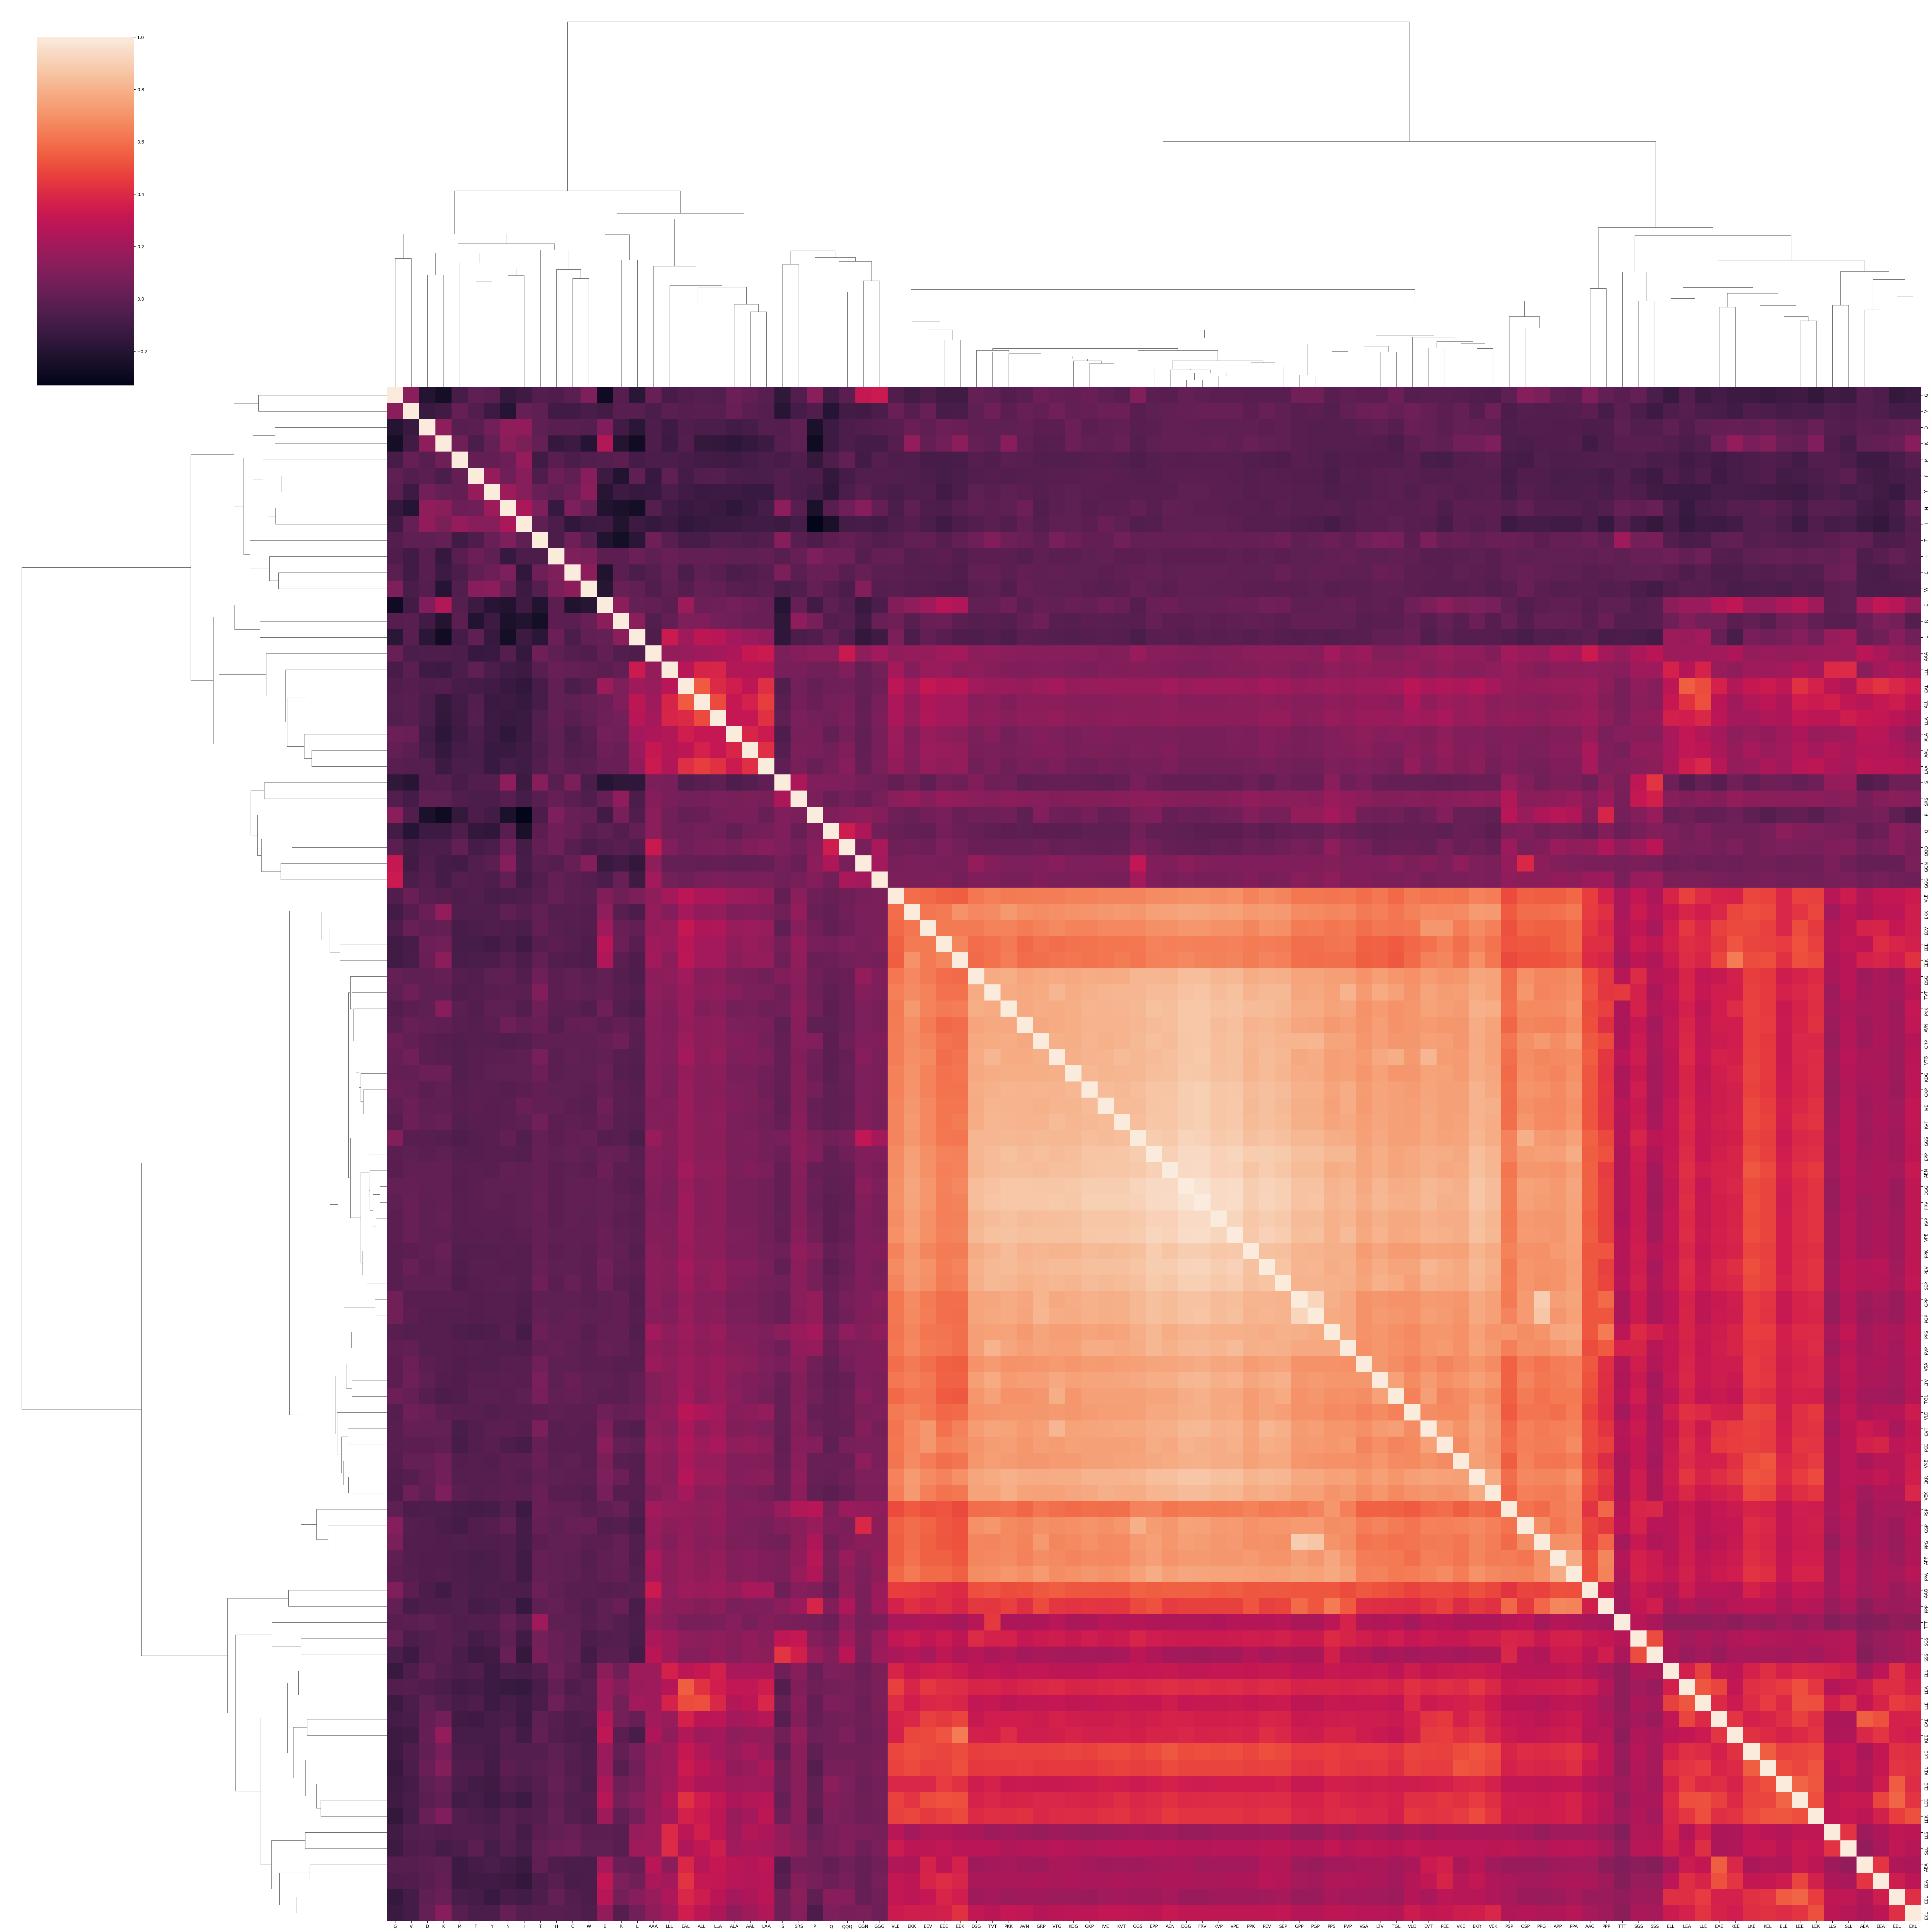

In [27]:
#Estabelecer uma matriz de correlação e visualizá-la em bruto e através de um clustermap
corr_matrix = data_scale.corr()
sn.clustermap(corr_matrix.iloc[1:,1:], figsize=(60,60))
corr_matrix

Ao analisar a matriz de correlação e respetivo clustermap, verificamos que existe um conjunto de features com um alto grau de correlação. A existência de features muito correlacionadas acrescenta pouca informação, aumentando a complexidade do modelo.
Observa-se, por exemplo, uma alta correlação entre as features:
- formulaC, formulaN, formulaO e formulaS, relativas à fórmula química;
- tamanho, carga, e coeficientes de extinção molar;
- os diferentes taus;
o que faz sentido do ponto de vista biológico.

Estas correlações são validadas pelo clustermap, que as agrupou.

Decidimos então eliminar as features com correlação muito elevada (considerando um threshold de 0.8).

In [28]:
# Obtenção das features com correlação muito elevada (de acordo com o threshold = 0.8)
max_corr=0.8
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > max_corr:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

print(len(correlated_features), correlated_features)



29 {'DSG', 'EVT', 'SEP', 'TVT', 'VPE', 'PEV', 'GRP', 'FRV', 'PPG', 'PPK', 'AVN', 'GPP', 'PEE', 'GGS', 'KVT', 'GKP', 'PGP', 'VEK', 'DGG', 'VTG', 'EPP', 'PKK', 'IVE', 'EKR', 'PPS', 'PVP', 'KDG', 'KVP', 'LTV'}


Dado o baixo valor informativo destas 29 features causada pela alta correlação, decidimos retira-las da análise seguinte de maneira a obter melhores resultados. Recalculando as correlações sem estas colunas obtemos um subconjunto de features com maior qualidade.


In [ ]:
#Eliminar features com correlação muito elevada
data_scale.drop(labels = correlated_features, axis = 1, inplace = True)

,A,R,N,D,C,E,Q,G,H,I,...,SRS,SGS,SLL,SSS,TGL,TTT,VLD,VLE,VKE,VSA
A,1.000000,0.038367,-0.283563,-0.228324,-0.135407,-0.066577,-0.044443,0.167569,-0.121499,-0.197928,...,-0.055803,-0.021809,-0.049008,-0.063210,-0.014690,-0.007948,-0.022357,-0.007451,-0.030863,0.038098
R,0.038367,1.000000,-0.235514,-0.098649,-0.017936,0.135225,-0.041070,-0.029746,-0.012815,-0.210232,...,0.149094,-0.038318,-0.020462,-0.023792,-0.013988,-0.039266,0.015561,0.040887,-0.027082,-0.027343
N,-0.283563,-0.235514,1.000000,0.150205,0.093038,-0.209825,-0.020682,-0.147527,-0.133207,0.233727,...,-0.025393,0.001960,-0.035189,0.028098,-0.025651,0.017912,-0.022345,-0.066709,-0.012643,-0.027075
D,-0.228324,-0.098649,0.150205,1.000000,-0.025737,0.099353,-0.112927,-0.204589,-0.024403,0.158104,...,-0.001717,-0.046183,-0.039668,-0.046028,-0.030657,-0.007951,0.031900,-0.020934,0.013865,-0.016002
C,-0.135407,-0.017936,0.093038,-0.025737,1.000000,-0.212421,0.033148,-0.017054,0.091560,-0.157461,...,-0.013353,-0.002095,0.042058,0.003761,0.020386,-0.003823,-0.011986,-0.015678,-0.008004,-0.004112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTT,-0.007948,-0.039266,0.017912,-0.007951,-0.003823,-0.005709,0.034065,-0.026074,0.001537,-0.036125,...,0.075460,0.269877,0.146380,0.230138,0.260839,1.000000,0.214736,0.221388,0.227685,0.252233
VLD,-0.022357,0.015561,-0.022345,0.031900,-0.011986,0.039360,0.009822,-0.037289,-0.000293,-0.021475,...,0.117936,0.313908,0.303665,0.213480,0.649520,0.214736,1.000000,0.630014,0.676223,0.656717
VLE,-0.007451,0.040887,-0.066709,-0.020934,-0.015678,0.105315,0.024521,-0.051848,0.013585,-0.055742,...,0.128437,0.305236,0.339932,0.225898,0.581246,0.221388,0.630014,1.000000,0.615376,0.594598
VKE,-0.030863,-0.027082,-0.012643,0.013865,-0.008004,0.087040,0.023913,-0.033625,-0.014189,-0.017633,...,0.132090,0.316241,0.287723,0.213098,0.679716,0.227685,0.676223,0.615376,1.000000,0.684328


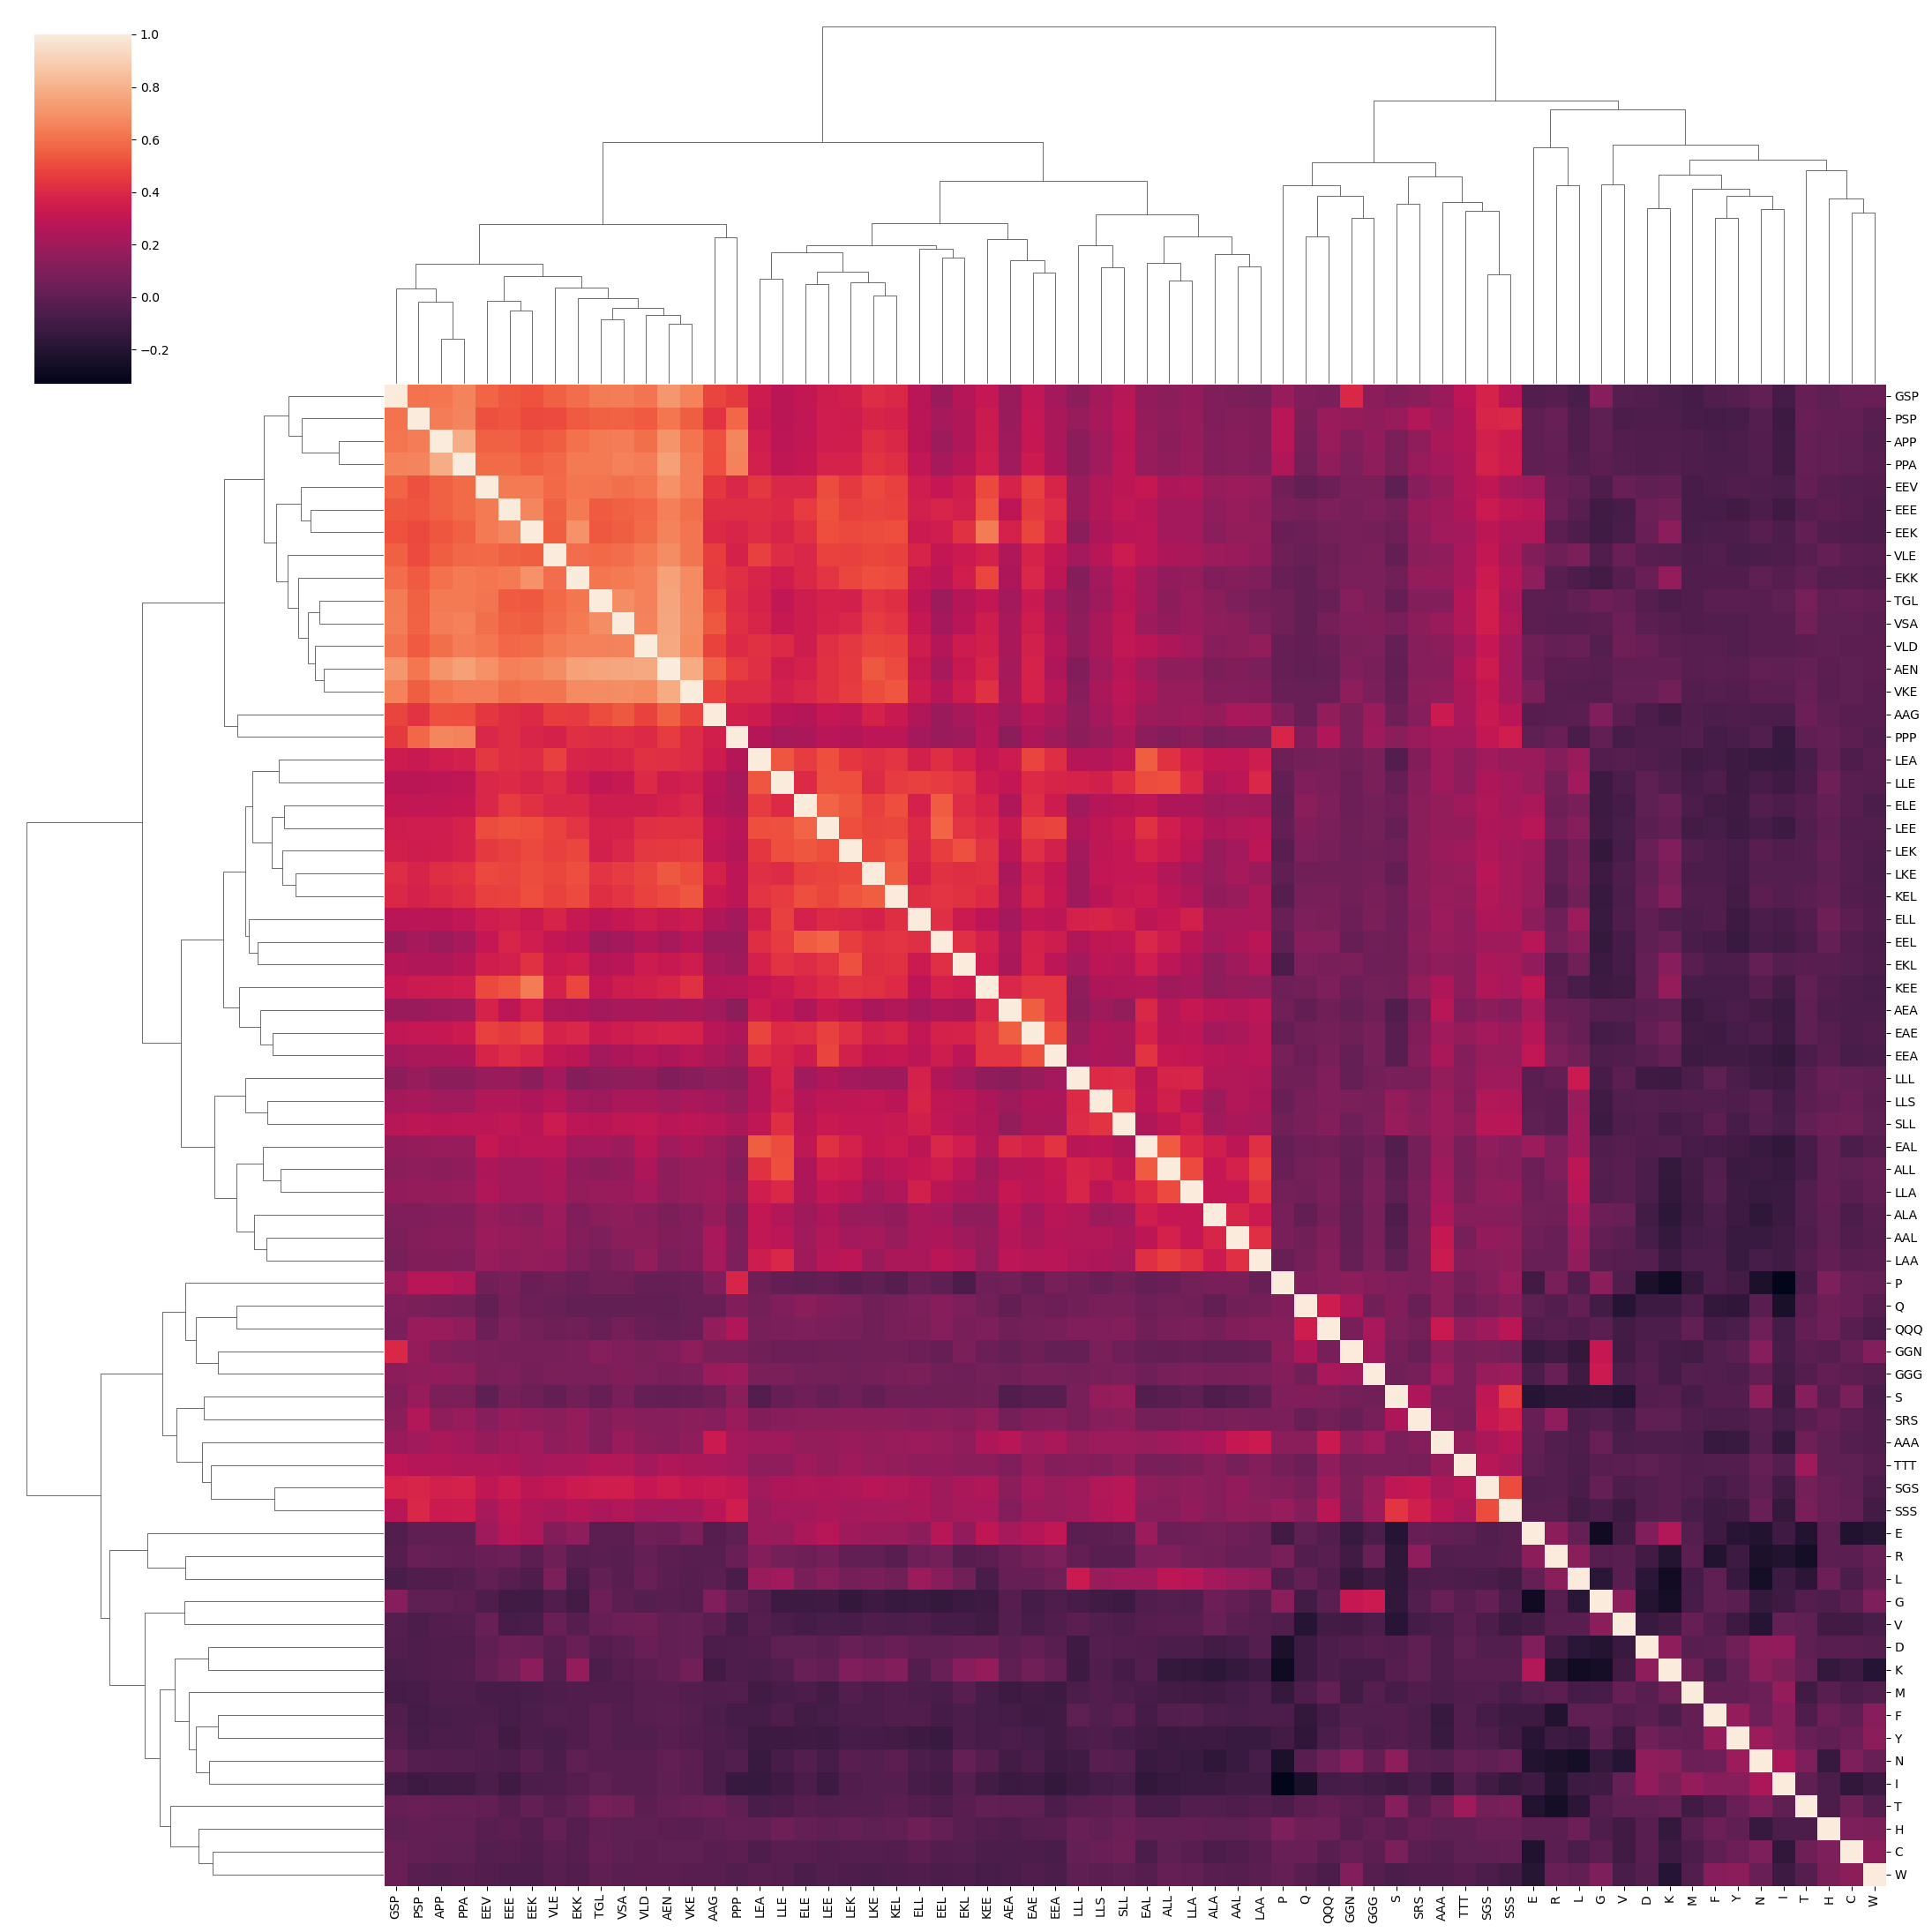

In [31]:
#Efetuar nova matriz de correlação e clustermap depois da eliminação de features muito correlacionadas
corr_matrix = data_scale.corr()
sn.clustermap(corr_matrix.iloc[1:,1:], figsize=(22,22))
corr_matrix

------------------------------------------------------------------------------------------------------------------------------------------------------

In [291]:
######################### CONCATENAR PARA DEPOIS SEPARAR - PORQUE? em cima já tinhamos o data_scale (X normalizado) e o Y separado
to_export = pd.concat([data_scale, Y_dataset],axis=1, ignore_index=False)
to_export.to_csv('datasets/all_descriptors_processed.csv')

In [34]:
######################### CONCATENAR PARA DEPOIS SEPARAR - - PORQUE? em cima já tinhamos o data_scale (X normalizado) e o Y separado

#data_scale = pd.read_csv('datasets/all_descriptors_processed.csv', delimiter = ',')
data_scale = pd.read_csv('C:/Users/sonia/Desktop/SIB_v1/kag/all_descriptors_processed.csv', delimiter = ',')

Y_dataset = data_scale["tm"].to_frame(name = "tm")
data_scale = data_scale.drop("tm", axis=1)

Caracterizámos ainda o Y - variável "tm", de forma a visualizar a distribuição dos dados.

                 tm
count  28344.000000
mean      48.955250
std       12.847299
min        9.800000
25%       42.300000
50%       47.900000
75%       53.300000
max       90.500000


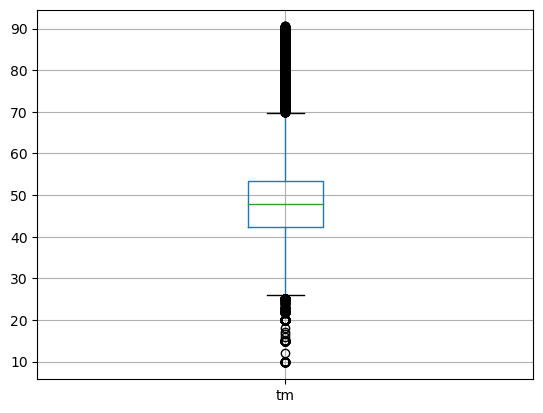

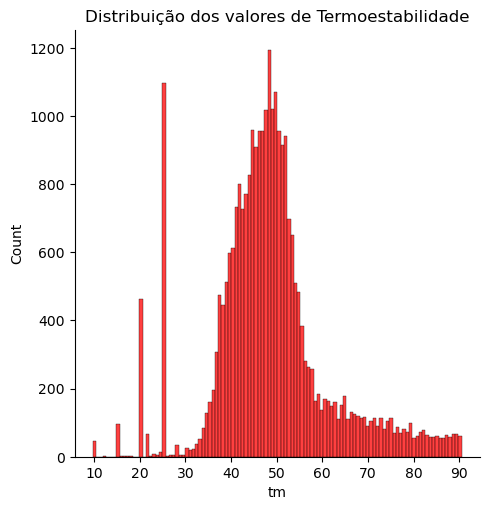

In [39]:
#Sumário de medidas estatísticas para Y (variável "tm"
summary = Y_dataset.describe()
print(summary)

#Visualização dos dados de Y (variável "tm") através de um boxplot
Y_dataset.boxplot()

sn.displot(data = Y_dataset, x = 'tm', color = 'red')
plt.xlabel('tm')
plt.title('Distribuição dos valores de Termoestabilidade')
plt.show()

 Verificámos que há uma distribuição assimétrica, com alguns "outliers". A região de valores mais comuns pertence ao intervalo entre `tm=30` e, aproximadamente, `tm=65`.


## Análise não supervisionada

Depois do pré-processamento dos dados, procedemos à análise através de métodos não supervisionados, permitindo visualizar e perceber melhor as características do nosso dataset.



De seguida, tentámos perceber se seria possível, de certa forma, agrupar os dados do Y (variável "tm") em "clusters", convertendo a variável contínua numa variável categórica.
Assim, efetuamos clustering hierárquico para visualizar o número de categorias que eventualmente poderiam ser definidas.


In [276]:
#Criar linkage matrix e fazer dendograma, incluindo as contagens de amostras para cada nodo
def linkage_matrix(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix


#Distance_threshold=0 assegura computação da árvore inteira
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)
matrix = linkage_matrix(model)


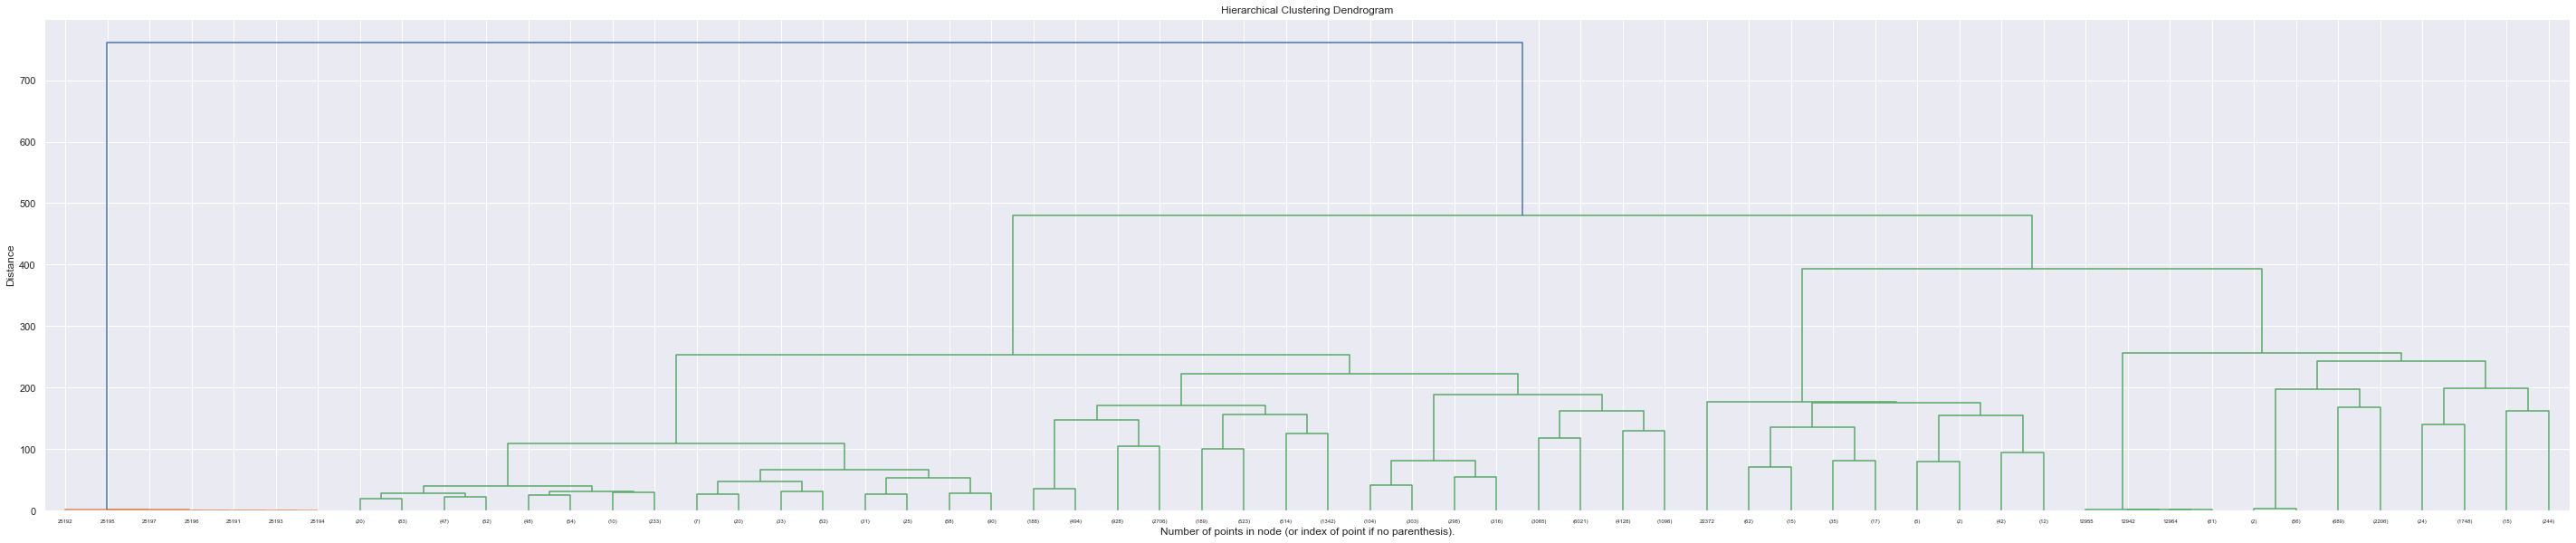

In [277]:
#Efetuar o gráfico de clustering
plt.figure(figsize=(50,10))
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(matrix, truncate_mode="level", p=6, leaf_rotation=0)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('Distance')
plt.show()

Ao visualizar o dendograma, constatamos que, para um corte correspondendo a distâncias inferiores a 0.5, um número de sete clusters parece ser adequado.

As mesmas conclusões são inferidas através da visualização de um outro dendograma. ####################NECESSÁRIO?



In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

#Criar linkage matrix e fazer o dendograma
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

# Distance_threshold=0 para assegurar a computação da árvore inteira
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


### Clustering aglomerativo

De seguida, efetuamos análise do clustering aglomerativo, tendo em conta as inferências obtidas no dendograma anterior. Considerámos um número de clusters igual a 7.

Desta forma, vamos explorar a possibilidade de prever o "tm" em formato categórico e verificar se os clusters gerados têm boa separação das categorias.

In [43]:
#Copiar a variável Y para criar nova variável categórica
Y_categorical = Y_dataset.copy()

#Para criar a nova variável categórica, pretendemos sete categorias, pelo que dividimos em sete o intervalo de valores da variável "tm"
min = 9.8
max = 90.5
step = (max-min)/7
bins = [min + i*step for i in range(7)]
bins.append(np.inf)
print(bins) 

#Criação da nova variável categórica, atribuindo labels apropriados
labels = [
    "muito baixo",
    "baixo",
    "baixo-médio",
    "médio",
    "médio-alto",
    "alto",
    "muito alto"
]
Y_categorical = pd.cut(Y_categorical['tm'], bins, labels=labels).to_frame(name = "tm")



[9.8, 21.32857142857143, 32.85714285714286, 44.385714285714286, 55.91428571428571, 67.44285714285714, 78.97142857142858, inf]


In [44]:
#Verificar o número de amostras por cada categoria da nova variável categórica
Y_categorical["tm"].value_counts()

médio          13626
baixo-médio     7428
médio-alto      2739
alto            1545
baixo           1358
muito alto      1036
muito baixo      611
Name: tm, dtype: int64

In [235]:
#Clustering aglomerativo considerando sete clusters
hclust = AgglomerativeClustering(n_clusters=7, affinity="euclidean", linkage="ward")
hclust.fit(X)
res_hc = hclust.labels_
pd.crosstab(Y_categorical["tm"], res_hc)

col_0,0,1,2,3,4,5,6
tm,,,,,,,
muito baixo,26,1,575,0,0,9,0
baixo,61,42,1005,7,69,174,0
baixo-médio,1589,172,3333,0,42,2283,9
médio,2856,337,6446,0,68,3897,22
médio-alto,374,37,1578,0,3,746,1
alto,144,14,1067,0,0,320,0
muito alto,109,6,669,0,1,251,0


Através da análise do clustering aglomerativo, observamos que os sete "clusters" permitem de certa forma efetuar um certo grau de distinção entre categorias. No entanto, verifica-se alguma sobreposição entre categorias, sobretudo em relação às categorias baixo-médio, médio e médio-alto.


Considerámos, então, a análise de clustering aglomerativo com apenas três clusters.



In [211]:
#Clustering aglomerativo com três clusters
hclust = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
hclust.fit(X)
res_hc = hclust.labels_
pd.crosstab(data_Y_categorical["tm"], res_hc)


col_0,0,1,2
tm,,,
muito baixo,27,0,584
baixo,172,7,1179
baixo-médio,1812,0,5616
médio,3283,0,10343
médio-alto,415,0,2324
alto,158,0,1387
muito alto,116,0,920


Ao efetuar análise de clustering aglomerativo com três clusters, verificamos uma maior sobreposição entre categorias, não permitindo a sua distinção.

De seguida foi então efetuado clustering K-Means, inicialmente considerando sete clusters.

In [215]:
#Clustering Kmeans
from sklearn.cluster import KMeans
k= 7

kmeans_dataset = KMeans(n_clusters=k, max_iter=1000)
kmeans_dataset.fit(X)
kmeans_dataset.predict(X)

labels = kmeans_dataset.labels_
print(labels)

centroids = kmeans_dataset.cluster_centers_
print(centroids)

pd.crosstab(labels,data_Y_categorical["tm"], rownames=['clusters'] )


[1 1 1 ... 1 1 0]
[[ 1.238e+03 -1.949e+01  6.063e+03  9.458e+03  1.637e+03  1.935e+03
   4.757e+01  1.386e+05  6.365e+00  4.470e+01  1.427e+05  1.440e+05
   8.094e+01  4.399e+02  4.493e+02  4.352e+02  4.351e+02  4.458e+02
   4.399e+02  4.493e+02  4.352e+02  4.351e+02  4.458e+02  1.797e+02
   2.522e+02  8.154e+01  8.415e+01  5.197e+01  6.959e+00  5.248e+00
   4.347e+00  5.549e+00  1.642e+00  7.061e+00  4.690e+00  6.596e+00
   2.419e+00  5.022e+00  9.401e+00  5.820e+00  2.193e+00  3.869e+00
   5.343e+00  7.659e+00  5.364e+00  1.534e+00  3.169e+00  6.115e+00
   9.627e-01  5.555e-01  7.493e-01  5.727e-01  2.604e-01  7.150e-01
   9.828e-01  4.063e-01  2.202e-01  2.826e-01  4.004e-01  6.096e-01
   9.544e-01  6.913e-01  9.124e-01  9.340e-01  5.954e-01  5.330e-01
   7.624e-01  9.029e-01  3.782e-01  7.991e-01  4.667e-01  2.297e-01
   3.625e-01  6.247e-01  2.344e-01  5.351e-01  5.561e-01  6.517e-01
   2.536e-01  3.072e-01  5.173e-01  2.590e-01  8.352e-01  7.422e-01
   8.946e-01  7.946e-01  9.254

tm,muito baixo,baixo,baixo-médio,médio,médio-alto,alto,muito alto
clusters,,,,,,,
0,27,119,1004,1907,208,66,47
1,584,1232,6424,11719,2531,1479,989
2,0,7,0,0,0,0,0


Os resultados foram sobreponíveis aos descritos anteriormente, verificando-se sobreposição entre categorias.

Foi então efetuado clustering K-Means, desta vez considerando três clusters.


In [216]:
from sklearn.cluster import KMeans
k=3

kmeans_dataset = KMeans(n_clusters=k, max_iter=1000)
kmeans_dataset.fit(X)
kmeans_dataset.predict(X)

labels = kmeans_dataset.labels_
print(labels)

centroids = kmeans_dataset.cluster_centers_
print(centroids)

pd.crosstab(labels,data_Y_categorical["tm"], rownames=['clusters'] )

[2 2 2 ... 2 2 0]
[[ 8.176e+02 -1.050e+01  4.017e+03  6.266e+03  1.082e+03  1.270e+03
   3.082e+01  9.152e+04  6.479e+00  4.356e+01  9.420e+04  9.495e+04
   8.170e+01  2.904e+02  2.973e+02  2.875e+02  2.870e+02  2.938e+02
   2.904e+02  2.973e+02  2.875e+02  2.870e+02  2.938e+02  1.718e+02
   2.350e+02  7.599e+01  7.718e+01  4.775e+01  7.167e+00  5.223e+00
   4.331e+00  5.560e+00  1.535e+00  7.065e+00  4.422e+00  6.640e+00
   2.370e+00  5.116e+00  9.387e+00  5.997e+00  2.253e+00  3.978e+00
   5.254e+00  7.431e+00  5.315e+00  1.483e+00  3.275e+00  6.199e+00
   6.811e-01  4.168e-01  5.535e-01  4.343e-01  1.706e-01  5.103e-01
   5.926e-01  2.726e-01  1.488e-01  1.922e-01  2.308e-01  4.194e-01
   5.385e-01  5.066e-01  6.543e-01  5.902e-01  4.442e-01  3.757e-01
   4.737e-01  5.923e-01  2.411e-01  5.111e-01  3.309e-01  1.640e-01
   2.269e-01  3.908e-01  1.502e-01  3.120e-01  3.989e-01  4.249e-01
   1.689e-01  2.222e-01  3.002e-01  1.803e-01  5.283e-01  4.477e-01
   5.955e-01  5.072e-01  6.086

tm,muito baixo,baixo,baixo-médio,médio,médio-alto,alto,muito alto
clusters,,,,,,,
0,27,113,1992,3580,452,189,142
1,0,7,0,0,0,0,0
2,584,1128,5317,9807,2272,1353,891
3,0,110,119,239,15,3,3


Mais uma vez, os resultados são sobreponíveis à análise de clustering anterior.


------------------------------
# PCA




Var. explicada: [9.726e-01 2.738e-02 6.944e-06 1.069e-06 1.816e-07 1.590e-07 7.979e-08]
Soma: 99.99997638969447 %



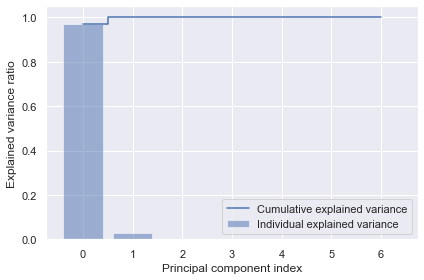

In [217]:
import matplotlib.pyplot as plt
%matplotlib inline
pca = PCA(n_components=7) #experimentar diferentes valores de n_components
pca.fit(X)

X_r = pca.transform(X) # transformacao dos dados no novo espaço utilizando apenas n CP

print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, "%")

print()

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

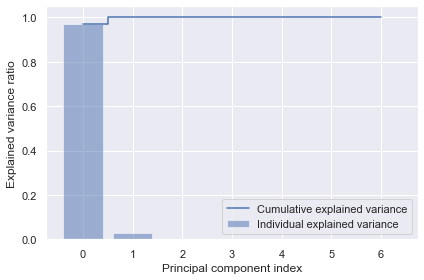

In [ ]:
meta_values = data_Y_categorical["tm"]
plt.figure()
for c, name in zip("rgb", ['muito baixo','baixo','baixo-médio','médio','médio-alto','alto','muito alto']):
    plt.scatter(X_r[meta_values == name, 0], X_r[meta_values == name, 1], c=c, label=name)
plt.legend()
plt.title('PCA - tm')
plt.show()


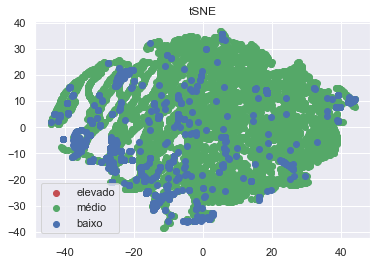

In [223]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, n_iter=1000)
points = tsne.fit_transform(X)
meta_values = data_Y_categorical["tm"]

plt.figure()
for c, name in zip("rgb", ["elevado", "médio", "baixo"]):
    plt.scatter(points[meta_values == name, 0], points[meta_values == name, 1], c=c, label=name)
plt.title("tSNE")
plt.legend(loc='best', shadow=False)
plt.show()


####COPIADO

data_Y_categorical = Y_categorical#.to_frame(name = "Y_categorical")

#frequencia de cada categoria
print('Frequência de cada categoria:\n')
data_Y_categorical.groupby("tm").size()


plt.figure()
for c, name in zip("rgb", ["elevado", "médio", "baixo"]):
    plt.scatter(x=(),, c=c, label=name)
plt.title("tSNE")
plt.legend(loc='best', shadow=False)
plt.show()


In [195]:
Y_categorical = Y_dataset.copy() #copia para não alterar Y (nota Y é array)

data_Y_categorical = Y_categorical

hclust = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="ward")
hclust.fit(X)
res_hc = hclust.labels_
pd.crosstab(data_Y_categorical["Y_categorical"], res_hc)


KeyError: 'Y_categorical'

In [ ]:

# criar variavel categorica dividindo os valores de tm de forma uniforme
min = 9.8
max = 90.5
step = (max-min)/7
bins = [min + i*step for i in range(7)]
bins.append(np.inf)
print(bins) 

labels = [
    "muito baixo",
    "baixo",
    "baixo-médio",
    "médio",
    "médio-alto",
    "alto",
    "muito alto"
]
Y_categorical = pd.cut(Y_categorical['tm'], bins, labels=labels).to_frame(name = "tm")


TypeError: 'value' must be an instance of str or bytes, not a float

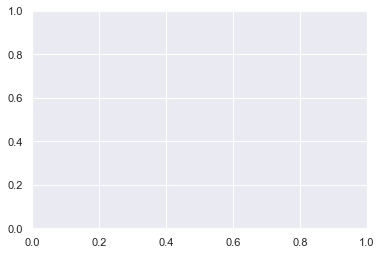

In [192]:
meta_values = Y_categorical["tm"]
plt.figure()
for c, name in zip("rgb", labels):
    plt.scatter(res_hc, Y_categorical["tm"], c=c, label=name)
plt.legend()
plt.title('AgglomerativeClustering - tm')
plt.show()


plt.bar(range(4), pca_SM.explained_variance_ratio_[:4]*100)
plt.xticks(range(4), ['PC'+str(i) for i in range(1,5)])
plt.title("Variância explicada por PC")
plt.ylabel("Percentagem")
plt.show()

Clustering kmeans

In [133]:
from sklearn.cluster import KMeans
k=6

kmeans_dataset = KMeans(n_clusters=k, max_iter=1000)
kmeans_dataset.fit(X)
kmeans_dataset.predict(X)

labels = kmeans_dataset.labels_
print(labels)

centroids = kmeans_dataset.cluster_centers_
print(centroids)

pd.crosstab(labels,Y["tm"], rownames=['clusters'] )

[0 0 2 ... 0 2 4]
[[ 2.512e+02 -1.615e+00  1.225e+03  1.939e+03  3.315e+02  3.840e+02
   9.612e+00  2.789e+04  6.948e+00  3.897e+01  2.173e+04  2.191e+04
   8.659e+01  9.087e+01  9.274e+01  8.874e+01  8.850e+01  9.028e+01
   9.087e+01  9.274e+01  8.874e+01  8.850e+01  9.028e+01  1.364e+02
   1.812e+02  6.011e+01  5.877e+01  3.274e+01  8.059e+00  5.466e+00
   4.176e+00  5.552e+00  1.412e+00  7.179e+00  3.952e+00  6.995e+00
   2.090e+00  5.691e+00  9.290e+00  6.880e+00  2.557e+00  3.691e+00
   4.425e+00  6.482e+00  5.249e+00  9.462e-01  2.975e+00  6.933e+00
   2.310e-01  1.697e-01  2.284e-01  1.366e-01  6.510e-02  2.116e-01
   2.062e-01  6.579e-02  7.659e-02  5.078e-02  9.140e-02  1.407e-01
   2.350e-01  1.588e-01  1.559e-01  1.745e-01  1.247e-01  1.218e-01
   1.244e-01  1.748e-01  6.805e-02  2.189e-01  1.072e-01  3.867e-02
   6.259e-02  5.524e-02  5.317e-02  5.141e-02  1.525e-01  1.012e-01
   6.610e-02  4.011e-02  5.053e-02  7.401e-02  1.964e-01  1.633e-01
   1.759e-01  1.520e-01  1.885

tm,9.8,9.9,10.0,12.0,15.0,16.0,16.6,17.2,18.0,20.0,...,89.6,89.7,89.8,89.9,90.0,90.1,90.2,90.3,90.4,90.5
clusters,,,,,,,,,,,,,,,,,,,,,
0,0,0,22,1,96,0,1,1,1,461,...,11,7,3,5,4,7,7,5,7,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,1,7,2,4,3,3,3,1,2,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,24,0,0,1,1,0,0,0,1,...,1,0,0,1,0,1,1,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
from sklearn.cluster import KMeans
k=12

kmeans_dataset = KMeans(n_clusters=k, max_iter=1000)
kmeans_dataset.fit(X)
kmeans_dataset.predict(X)

labels = kmeans_dataset.labels_
print(labels)

centroids = kmeans_dataset.cluster_centers_
print(centroids)

pd.crosstab(labels,Y["tm"], rownames=['clusters'] )


[2 2 5 ... 2 5 4]
[[ 4.618e+02 -4.546e+00  2.301e+03 ...  1.153e-01  1.614e-01  1.332e-01]
 [ 3.277e+04 -3.296e+02  1.611e+05 ...  8.200e+01  3.700e+01  5.100e+01]
 [ 2.689e+02 -1.713e+00  1.315e+03 ...  7.597e-02  1.030e-01  7.520e-02]
 ...
 [ 6.455e+02 -7.925e+00  3.213e+03 ...  1.563e-01  1.730e-01  1.624e-01]
 [ 1.267e+03 -1.504e+01  6.130e+03 ...  3.627e-01  4.684e-01  3.007e-01]
 [ 1.661e+02 -1.601e-01  8.054e+02 ...  3.672e-02  7.742e-02  7.568e-02]]


tm,9.8,9.9,10.0,12.0,15.0,16.0,16.6,17.2,18.0,20.0,...,89.6,89.7,89.8,89.9,90.0,90.1,90.2,90.3,90.4,90.5
clusters,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,1,1,2,2,0,2,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,93,0,1,0,0,428,...,6,2,1,1,0,4,4,2,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
5,0,0,5,0,0,0,0,0,0,4,...,2,5,2,4,3,1,1,3,2,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


------------------------------------------------------------------------------------------------------------------------------------------------------

PCA

Var. explicada: [9.726e-01 2.738e-02 6.944e-06 1.069e-06 1.816e-07]
Soma: 99.99995251575073 %


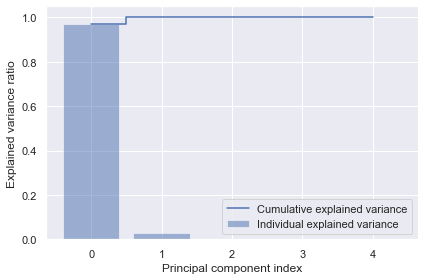

In [158]:
pca = PCA(n_components=5) #experimentar diferentes valores de n_components
pca.fit(X)

X_r = pca.transform(X) # transformacao dos dados no novo espaço utilizando apenas n CP

print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, "%")

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

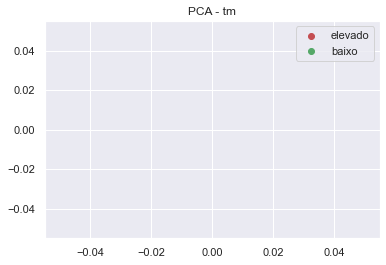

In [159]:
meta_values = Y["tm"]
plt.figure()
for c, name in zip("rgb", ["elevado", "baixo"]):
    plt.scatter(X_r[meta_values == name, 0], X_r[meta_values == name, 1], c=c, label=name)
plt.legend()
plt.title('PCA - tm')
plt.show()


Considerando dois componentes principais, apenas é explicada cerca de 50% da variabilidade do dataset. Neste caso, observa-se ainda marcada sobreposição / similaridade das duas categorias (tm alto / baixo) da variável dependente.

Uma vez que pretendiamos um número de componentes principais que explicasse pelo menos 95% da variabilidade do dataset, fizemos um gráfico que nos permitisse inferir esse valor.


In [ ]:
pca = PCA().fit(X)

plt.rcParams["figure.figsize"] = (8,5)

fig, ax = plt.subplots()
xi = np.arange(1, 23, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 14, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.savefig('pcavisualize_1.png', dpi=300)
plt.show()

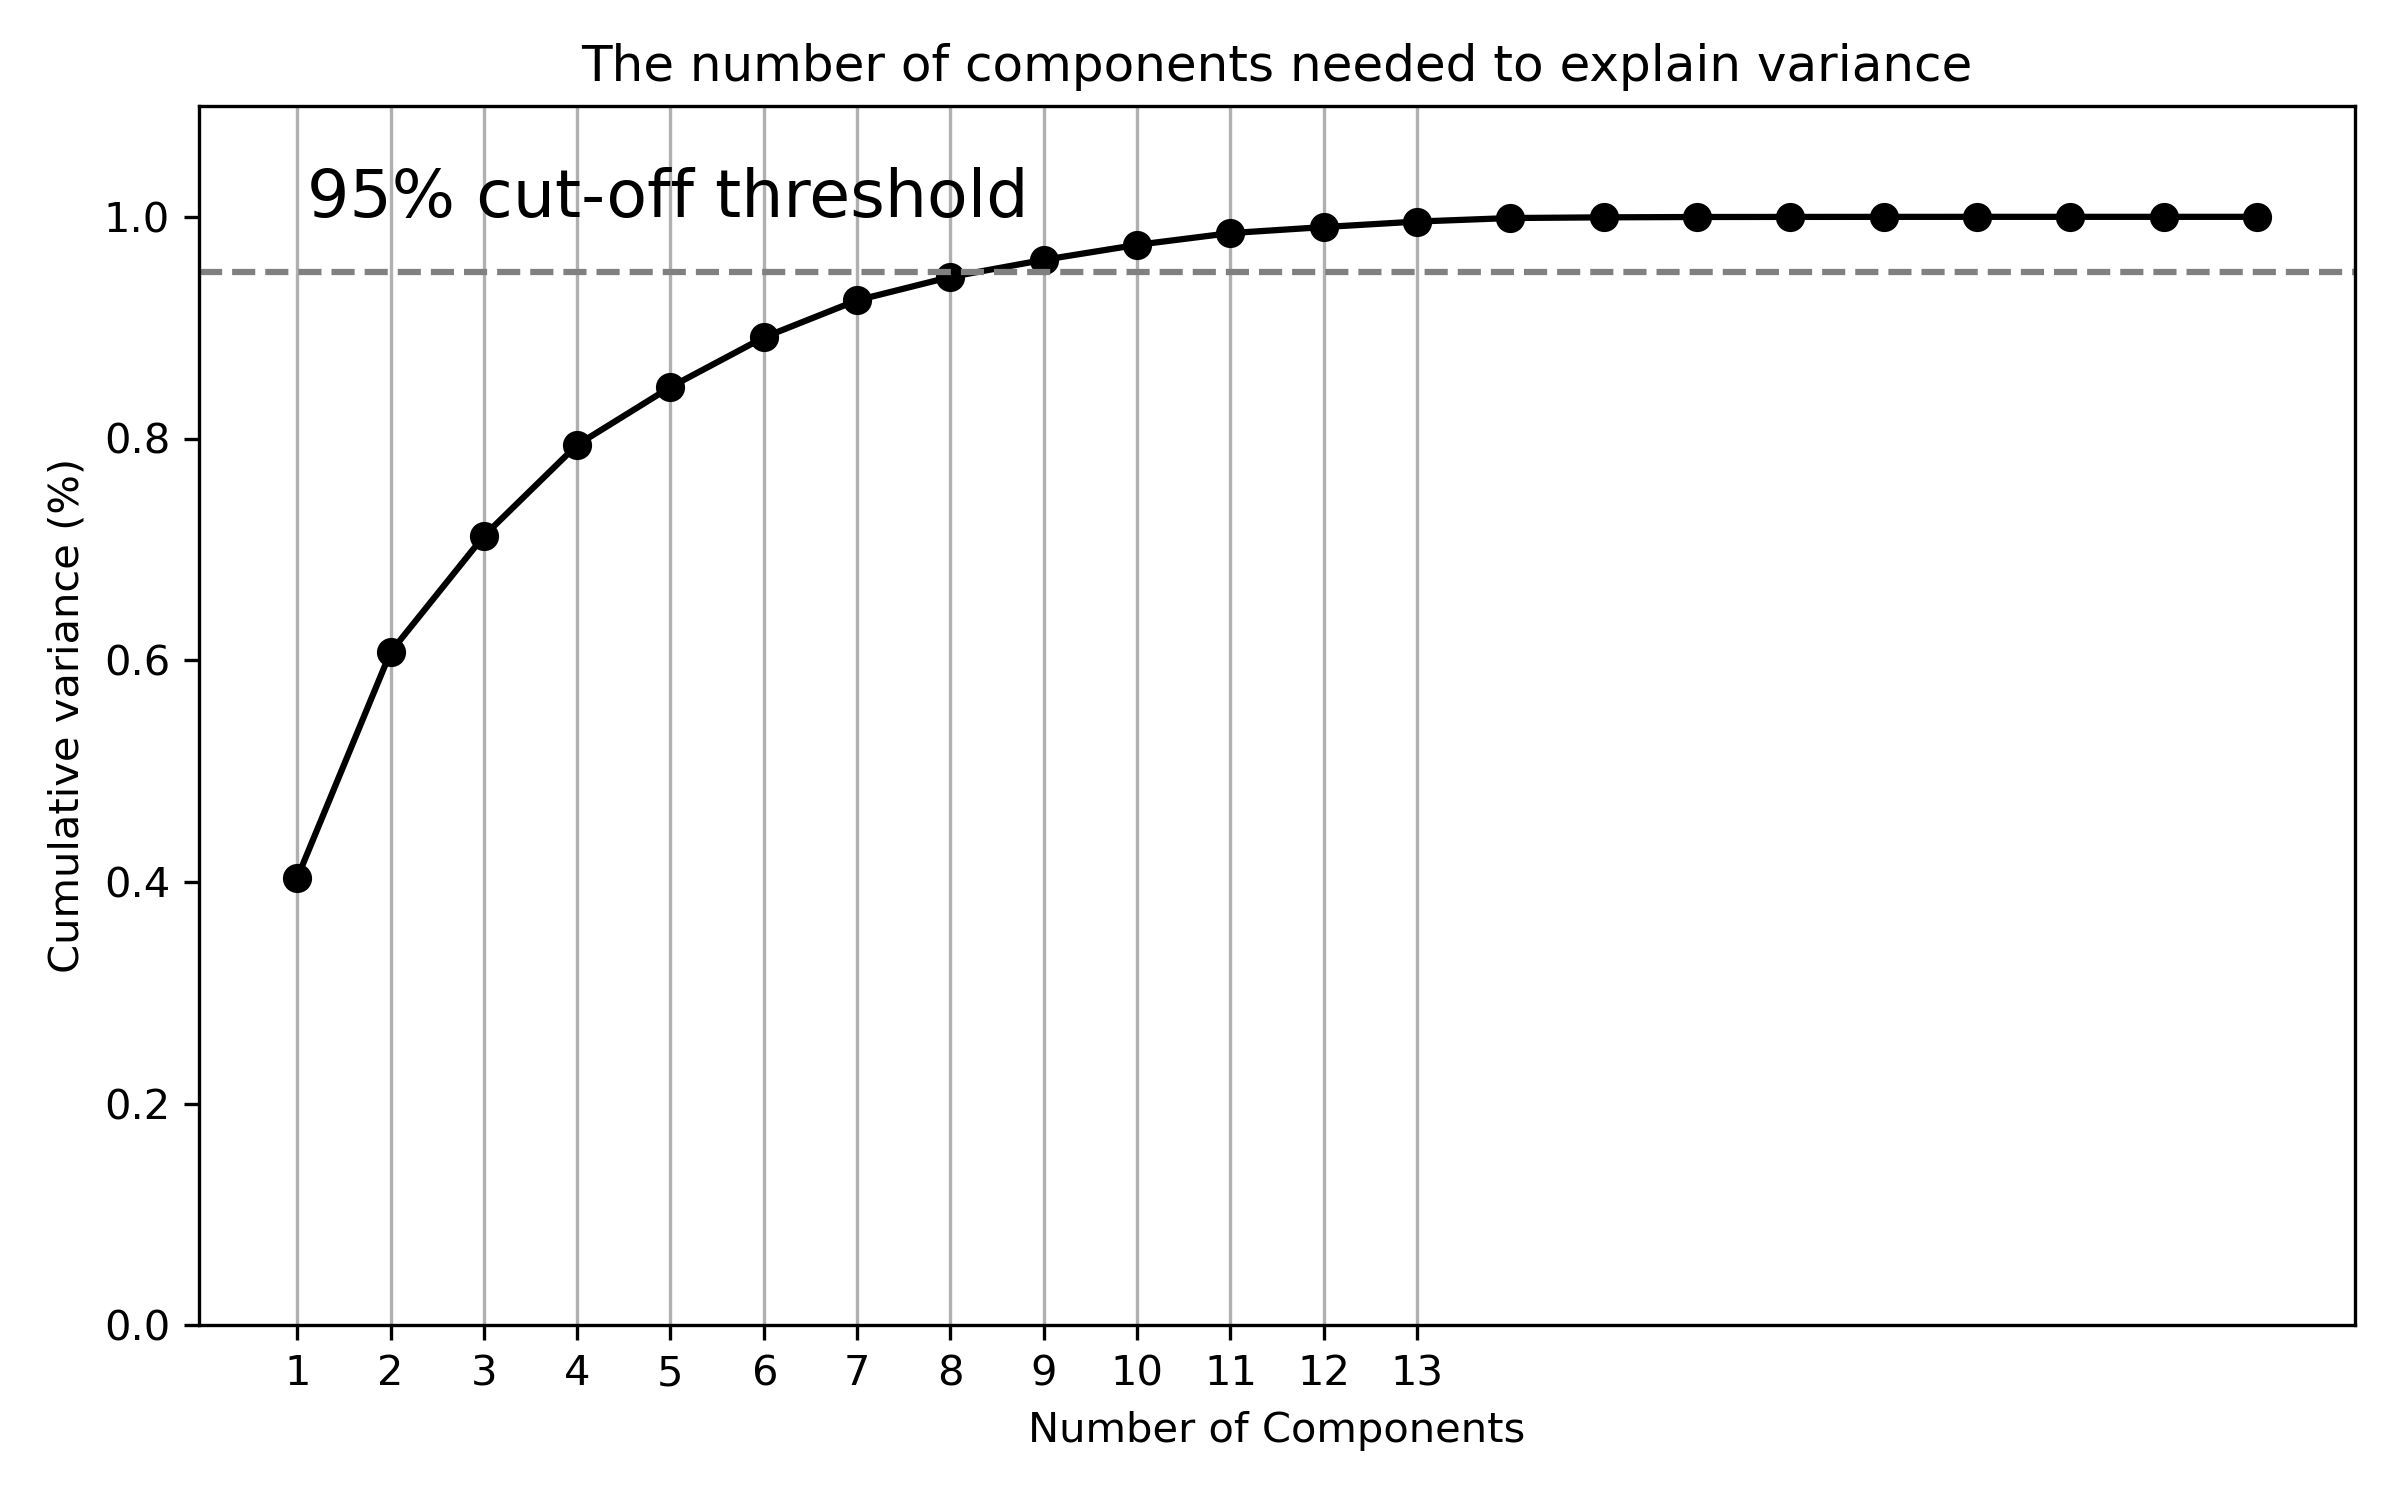


Assim, concluimos ser possível prever uma variabilidade do dataset superior a 95% ao somar as variâncias cumulativas esperadas de oito componentes principais.

Tal como esperado, o aumento do número de componentes principais conduz a uma maior soma cumulativa das variâncias esperadas. Se pretendessemos reduzir a dimensionalidade do dataset, poderiamos usar apenas esses componentes nas análises seguintes e, num processo iterativo, verificar se seriam obtidos resultados melhores.


In [29]:
pca = PCA(n_components=8)
pca.fit(X)

X_r = pca.transform(X) #

print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, "%")

Var. explicada: [0.29  0.184 0.139 0.094 0.09  0.073 0.062 0.033]
Soma: 96.52637164900989 %


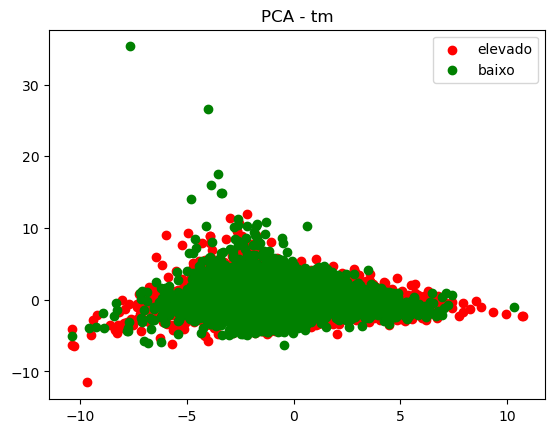

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

TSNE

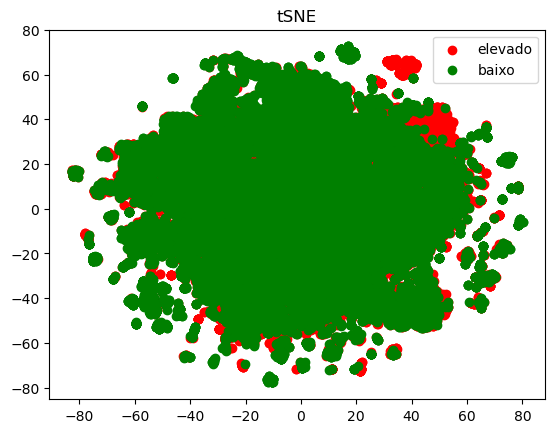

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=1000)
points = tsne.fit_transform(X)
meta_values = Y["Y_categorical"]

plt.figure()
for c, name in zip("rgb", ["elevado", "baixo"]):
    plt.scatter(points[meta_values == name, 0], points[meta_values == name, 1], c=c, label=name)
plt.title("tSNE")
plt.legend(loc='best', shadow=False)
plt.show()


------------------------------------------------------------------------------------------------------------------------------------------------------

# Etapa 3 - Aprendizagem máquina

Vamos agora proceder ao treino de modelos de diferentes naturezas e estudar a sua capacidade de prever a termoestabilidade.

A partir deste momento, o nosso y é uma variavel binaria em que 0 representa um tm baixo em relação à média e 1 reprensenta um tm elevado em relação à média.

In [262]:
data_y = Y_categorical.replace(["muito baixo","baixo","baixo-médio","médio","médio-alto","alto","muito alto"], [0,1,2,3,4,5,6])
data_y.groupby("tm").size()

tm
0      611
1     1358
2     7428
3    13626
4     2739
5     1545
6     1036
dtype: int64

Existem 16 341 valores de tm inferiores à média e 12 398 valores de tm superiores à média

In [263]:
data_y.groupby("tm").size()

tm
0      611
1     1358
2     7428
3    13626
4     2739
5     1545
6     1036
dtype: int64

Dividir os dados em treino e em teste

In [264]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y_categorical, test_size = 0.25, random_state = 500)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (21258, 124) (21258, 1)
Test:  (7086, 124) (7086, 1)


Regressão e curva roc

In [251]:
# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression()
# model.fit(X_train,y_train)

In [265]:
def score_test_set(model, X_test, y_test):
    # score test set
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)
    except:
        y_prob = None
    print('accuracy', accuracy_score(y_test, y_pred))
    print('MCC', matthews_corrcoef(y_test, y_pred))
    print('f1 score', f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('fdr', float(fp) / (tp + fp))
    print('sn', float(tp) / (tp + fn))
    print('sp', float(tn) / (tn + fp))

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [260]:
score_test_set(model, X_test, y_test)
# ROC_AUC
# prediction = model.predict_proba(X_test)

preds = model.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'g', label='AUC = %0.3f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('ROC AUC score:', round(roc_auc, 4))

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

##### --> Regressão Logística e curva ROC:

Obtivemos um f1-score de 0.72 para termoestabilidade baixa, e 0.40 para elevada. 

A área sob a curva AUC resume a performance do modelo;
A forma da curva mostra a taxa de falsos positivos esperada e a taxa de falsos negativos; É apropriada quando as observações são balanceadas entre as classes.

Quanto menores os valores no eixo x indica menos falsos positivos e mais verdadeiros negativos.
Quanto maiores os valores no eixo y indica mais verdadeiros positivos e menos falsos negativos.

Neste caso, os valores estão mais próximos do eixo y, mostrando assim que temos mais valores Verdadeiros Positivos do que Falsos Negativos.

------------------------------------------------------------------------------------------------------------------------------------------------------

Comparar os modelos com e sem pesos

Como as proporções entre as 2 categorias de y são diferentes, os pesos vão ser diferentes também.
Assim, para a categoria '0' que tem 16 341, a proporção vai ser de 0.75, enquanto que para a categoria '1' que tem 12 398, a porpoção vai ser 1.

In [267]:
#Test and compare multiple models
class_weight={0:1/7,  1:2/7, 2:3/7, 3:4/7, 4:5/7, 5:6/7, 6:1}
#class_weight={0: 0.75, 1: 1}
models = [('LR', LogisticRegression()),
          ('LR-W', LogisticRegression(class_weight=class_weight)),
          ('RF', RandomForestClassifier()),
          ('RF-W', RandomForestClassifier(class_weight=class_weight)),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()),
          ('SVM-W', SVC(class_weight=class_weight)),
          ('DT', DecisionTreeClassifier()),
          ('DT-W', DecisionTreeClassifier(class_weight=class_weight))]


names = []
results = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cross_val = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    results.append(cross_val)
    names.append(name)
    msg = "%s: %f SD:%f" % (name, cross_val.mean(), cross_val.std())
    print(msg)


LR: nan SD:nan


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 1196, in fit
    X, y = self._validate_data(
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py", line 554, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py", line 1120, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py", line 1142, in _check_y
    _assert_all_finite(y, input_name="y", estimator_name=estimator_name)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py", line 111, in _assert_all_finite
    raise ValueError("Input contains NaN")
ValueError: Input contains NaN

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\_parallel_backends.py", line 597, in __init__
    self.results = batch()
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 320, in _logistic_regression_path
    class_weight_ = compute_class_weight(class_weight, classes=classes, y=y)
  File "c:\Users\Afonso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\class_weight.py", line 72, in compute_class_weight
    raise ValueError(
ValueError: The classes, ['alto', 'baixo', 'baixo-médio', 'muito alto', 'muito baixo', 'médio', 'médio-alto'], are not in class_weight


plot dos resultados -- all models

NameError: name 'results' is not defined

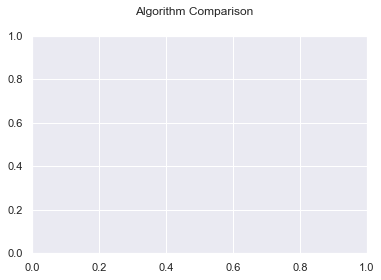

In [239]:
# Plot the results
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Os valores de cross val vão de 0.0 a 1.0, onde quanto mais próximo de 1.0, melhor.
Neste caso podemos observar que os melhores modelos paratreinar os dados são: 

    - Regressão logistica com pesos
    - Random Forest com e sem pesos
    - KNN
    - SVM com pesos
    - Decision trees com e sem pesos
    


In [ ]:
columns = X.columns
columns

SVM

In [ ]:
param_grid = {'C': [0.01,0.1,1],
#               'C': [0.1, 1, 10]
              'kernel': ['linear']}

#hyperparameter optimization algorithm
grid = GridSearchCV(SVC(), param_grid, cv=5, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(X_train, y_train)
print(grid.best_params_)


#SCORE THE TEST SET
score_test_set(grid, X_test, y_test)


#feature importance
pd.Series(abs(grid.best_estimator_.coef_[0]), index=columns).nlargest(20).plot(kind='barh')


No SVM podemos ver que os melhores parâmetros foram : {'C': 1, 'kernel': 'linear'}. Apresenta uma accuracy de 0.61 e um f1 score de 0.22. 
Pela matriz de confusao podemos ver que existe um elevado número de Falsos Positivos (2651).

Regressão logistica sem peso com RandomizedSearchCV

In [ ]:
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,random_state=0)

distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])

clf = RandomizedSearchCV(logistic, distributions, random_state=0)
clf
search = clf.fit(X_train, y_train)
search.best_params_

score_test_set(search, X_test, y_test)

pd.Series(abs(search.best_estimator_.coef_[0]), index=columns).nlargest(20).plot(kind='barh')

No LR com RandomizedSearch podemos ver que:

Apresenta uma accuracy de:  0.61

Apresenta um f1 score de: 0.39

Pela matriz de confusao podemos ver que existe um elevado número de Falsos Positivos (2143).

RandomForest sem pesos com RandomizedSearchCV¶

In [ ]:
param_grid = {'n_estimators': [10, 100, 200]}

#hyperparameter optimization algorithm
grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=5, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(X_train, y_train)
print(grid.best_params_)
#SCORE THE TEST SET
score_test_set(grid, X_test, y_test)

# feature importance for RF
pd.Series(abs(grid.best_estimator_.feature_importances_), index= columns).nlargest(20).plot(kind='barh')

Feature selection

Select Percentile

In [ ]:
select = SelectPercentile(score_func = f_classif, percentile = 25)
select.fit(X_train, y_train)

train_x = select.transform(X_train)
test_x = select.transform(X_test)

model = LogisticRegression()

#cross validation
scores = cross_val_score(clf, train_x, y_train, cv=5)
print('Scores: ', scores)

Apresenta uma accuracy de:  0.67

Apresenta um f1 score de: 0.56

Pela matriz de confusao podemos ver que existe um número menor de Falsos Positivos (1511).

Variance Threshold

# Etapa 4 - Deep learning
Nas partes iniciais foram realizadas actividades de limpeza dos dados, estudo das featurese e feature engineering, dando-nos agora um dataset de maior qualidade para usar no desenvolvimento duma rede neuronal capaz de prever o `tm` de forma adequada. Para tal, há alguns factores que precisamos de ter em conta ao densenvolver o modelo, nomeadamente:
- É importante saber qual deve ser a estrutura do modelo - número de camadas, tipos de layers, número de nodos das camadas, etc. 
- Para além dos parâmetros (que a própria rede vai procurar optimizar), existem também os hiperparâmetros, cuja optimização não é parte do algoritmo de backpropagation, e deve também ser feita.

In [274]:
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Sequential
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 500)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)


Train:  (22675, 124) (22675, 1)
Test:  (5669, 124) (5669, 1)


In [272]:
# funções auxiliares
def print_model(model,fich):
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)

def create_time_steps(length):
  return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
  print(history)
  print(true_future)
  print(prediction)
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/72, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/72, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()